In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [30]:
# Load cleaned data
data_type = 'clean_enriched'
data = pd.read_csv(data_type + '_train.csv', sep=';', decimal=',')

In [31]:
# Split data to separate 'y' and 'X'.
y = data['EXTRA_BAGGAGE']

# Drop target variable from X DataFrame
X = data.drop('EXTRA_BAGGAGE', 1)

In [25]:
# We'll apply nested cross-validation in order to avoid the possible bias of applying 
# cross-validation combined with grid-search to perform parameter tuning.

# We'll use nested cross-validation over several classification methods in order to
# obtain their generalization score and choose the one with highest score. After this,
# we'll perform a simple cross-validation with grid-search in order to obtain the 
# best configuration of hyper-parameters for this algorithm. Finally we'll train 
# the model with all the training data and the hyper-parameter configuration that
# yield the best results.

# variace: it removes useless variables with variace equal to zero.
# scaler: standardizes each column to have mean equal to zero and variance equal to 1, 
# in order to give same importance to variables with different measurement units.
lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(lr_nested_cv_f1_scores, data_type + '_lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(lr_nested_cv_f1_scores), "std =", np.std(lr_nested_cv_f1_scores))
print()

##### Encoded:  Generalization F1 Score: mean = 0.663232566525 std = 0.00577941758843
##### Binarized Generalization F1 Score: mean = 0.662300707325 std = 0.00639698194352
##### Enriched: Generalization F1 Score: mean = 0.668949634197 std = 0.00667454322097

[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.663875, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.666581, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.655559, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.658403, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...........

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] ...................... lr__C=0.001, score=0.665266, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.666647, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.680555, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.665054, total=   0.6s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


[CV] ....................... lr__C=0.01, score=0.666537, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.670445, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.667551, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662115, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.671088, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.665887, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.668163, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


[CV] ....................... lr__C=0.01, score=0.670472, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.684359, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.667932, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.666023, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663811, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671767, total=   0.9s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


[CV] ........................ lr__C=0.1, score=0.668148, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663494, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.666386, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.672631, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.684968, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.674215, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.668333, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s


[CV] .......................... lr__C=1, score=0.672943, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.673236, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.663682, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.674630, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.665800, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.685354, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668527, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


[CV] ......................... lr__C=10, score=0.672943, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662846, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668148, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.673236, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.674437, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.665409, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.663878, total=   1.0s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s


[CV] ........................ lr__C=100, score=0.673137, total=   1.2s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.668148, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.673236, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.663878, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.674437, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.665409, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.685547, total=   0.6s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.3s finished


[CV] ................................. , score=0.662433, total=  16.8s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.659853, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.656798, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.657334, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.666032, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.660637, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.667361, total=   0.4s
[CV] l

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


[CV] ...................... lr__C=0.001, score=0.661203, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.663123, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.665514, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.680579, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660873, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662364, total=   0.6s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


[CV] ....................... lr__C=0.01, score=0.661908, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.671873, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.665987, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669873, total=   0.9s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663130, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.669377, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.664057, total=   0.8s
[CV] ....................... lr__C=0.01, score=0.684237, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] l

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


[CV] ........................ lr__C=0.1, score=0.662695, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662599, total=   0.9s
[CV] ........................ lr__C=0.1, score=0.664236, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.670227, total=   1.0s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


[CV] ........................ lr__C=0.1, score=0.666973, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663094, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671873, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.664823, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.671341, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.684057, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.664422, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


[CV] .......................... lr__C=1, score=0.670822, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.667170, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.672289, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662890, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.666014, total=   0.9s
[CV] .......................... lr__C=1, score=0.671535, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.684070, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


[CV] ......................... lr__C=10, score=0.667170, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.671016, total=   1.4s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.672485, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662489, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.665819, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.671535, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.662199, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.8s


[CV] ........................ lr__C=100, score=0.667170, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.672485, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.662686, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.665819, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.671535, total=   0.9s
[CV] ........................ lr__C=100, score=0.684458, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.662199, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.5s finished


[CV] ................................. , score=0.668504, total=  17.0s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.9s remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.661650, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655353, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.656933, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.670389, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.660043, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.678841, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.665124, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663572, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659806, total=   0.6s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


[CV] ....................... lr__C=0.01, score=0.674013, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662874, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669511, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.666381, total=   0.9s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664331, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.667994, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.665427, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


[CV] ....................... lr__C=0.01, score=0.683643, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661894, total=   0.7s
[CV] ........................ lr__C=0.1, score=0.662213, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660634, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.674377, total=   0.9s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


[CV] ........................ lr__C=0.1, score=0.665384, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.673293, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.665214, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.661516, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.671354, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.682606, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660634, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


[CV] .......................... lr__C=1, score=0.666954, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.672289, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662481, total=   0.9s
[CV] .......................... lr__C=1, score=0.665223, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.672737, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.683822, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660634, total=   1.0s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s


[CV] ......................... lr__C=10, score=0.674778, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.666954, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662285, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.672289, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.665623, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.672543, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.683629, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.6s


[CV] ........................ lr__C=100, score=0.672289, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.666954, total=   1.0s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.674584, total=   1.2s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.662285, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.665623, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.672543, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.683629, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.5s finished


[CV] ................................. , score=0.668387, total=  17.0s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.9s remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.662206, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.658419, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.662716, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.668024, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.667570, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] ...................... lr__C=0.001, score=0.664458, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.685218, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.667253, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.665466, total=   0.6s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


[CV] ....................... lr__C=0.01, score=0.661142, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.672070, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.667167, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.668921, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.672273, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664066, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.668110, total=   0.6s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s


[CV] ....................... lr__C=0.01, score=0.671882, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.689080, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.665299, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662689, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.675385, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.666962, total=   0.8s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


[CV] ........................ lr__C=0.1, score=0.669903, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.675015, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.665800, total=   0.9s
[CV] ........................ lr__C=0.1, score=0.667916, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.674007, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.686512, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.664908, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


[CV] .......................... lr__C=1, score=0.666366, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.668914, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.675006, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.666005, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.668121, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.674186, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.686497, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s


[CV] ......................... lr__C=10, score=0.675178, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.666366, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.669110, total=   1.0s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.666200, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.674810, total=   1.2s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.668316, total=   1.1s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.674186, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.7s


[CV] ........................ lr__C=100, score=0.669110, total=   1.1s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.666366, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.674810, total=   1.3s
[CV] ........................ lr__C=100, score=0.666005, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.668316, total=   1.2s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.674186, total=   1.3s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.664908, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   19.4s finished


[CV] ................................. , score=0.668659, total=  19.9s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.659280, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.656139, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.664541, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.665650, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.658214, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.660615, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.663944, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661610, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.680786, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659015, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] ....................... lr__C=0.01, score=0.667782, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662700, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669918, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.670285, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662541, total=   0.6s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] ....................... lr__C=0.01, score=0.665650, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.666647, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.684651, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660044, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.669743, total=   0.5s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659806, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671028, total=   0.9s
[CV] ........................ lr__C=0.1, score=0.663089, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


[CV] ........................ lr__C=0.1, score=0.671904, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662330, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.670165, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.665819, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660431, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.683463, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660011, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.670639, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.671300, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662309, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.665623, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.670553, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.684057, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660431, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s


[CV] ......................... lr__C=10, score=0.670227, total=   1.0s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.663844, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.671300, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662505, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.670553, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.665232, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.684057, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


[CV] ........................ lr__C=100, score=0.663844, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.671300, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.662505, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.670227, total=   1.5s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.670553, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.665232, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.684057, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.0s finished


[CV] ................................. , score=0.662093, total=  16.5s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.661256, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.656511, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.665917, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.666637, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.653763, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.662527, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.665697, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.680397, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


[CV] ....................... lr__C=0.01, score=0.659015, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661820, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669548, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.671635, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.668745, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659905, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.665109, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] ....................... lr__C=0.01, score=0.668394, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.683282, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661368, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661806, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.670913, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.672253, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660485, total=   0.6s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s


[CV] ........................ lr__C=0.1, score=0.668345, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663509, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.666628, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.673070, total=   0.7s
[CV] ........................ lr__C=0.1, score=0.683643, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662178, total=   0.9s
[CV] .......................... lr__C=1, score=0.661610, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


[CV] .......................... lr__C=1, score=0.672058, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.668745, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660678, total=   0.9s
[CV] .......................... lr__C=1, score=0.664082, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.667233, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.673221, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.683435, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s


[CV] ......................... lr__C=10, score=0.671118, total=   0.6s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660291, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668745, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.672253, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.664866, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.673414, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.667037, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.4s


[CV] ........................ lr__C=100, score=0.660291, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.672253, total=   1.1s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.664866, total=   0.5s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.668745, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.667037, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.673414, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.683435, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.1s finished


[CV] ................................. , score=0.670348, total=  16.6s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.661391, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.656880, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.665086, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.665837, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.656489, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.664334, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.682714, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663139, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659746, total=   0.6s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] ....................... lr__C=0.01, score=0.671086, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661300, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.671016, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669170, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.668263, total=   0.6s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] ....................... lr__C=0.01, score=0.665595, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.685324, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.669878, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.665104, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660567, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.672276, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.673551, total=   1.0s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


[CV] ........................ lr__C=0.1, score=0.662995, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.669607, total=   0.6s
[CV] ........................ lr__C=0.1, score=0.671525, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.664375, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.673070, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.664126, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.684596, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s


[CV] .......................... lr__C=1, score=0.661036, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.673938, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.669411, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.672129, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.664990, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.672089, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.663930, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s


[CV] ......................... lr__C=10, score=0.673271, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.661036, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.673938, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.672129, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.669411, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.664599, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.671882, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.1s


[CV] ........................ lr__C=100, score=0.673938, total=   1.0s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.661036, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.672129, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.669411, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.664404, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.671882, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.663930, total=   0.6s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.9s finished


[CV] ................................. , score=0.666938, total=  16.5s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.660227, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.663537, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655143, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.666245, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.661854, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.654963, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] ...................... lr__C=0.001, score=0.664787, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.679436, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.663164, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659601, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662968, total=   0.7s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669343, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660719, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.670274, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.666615, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.670892, total=   0.6s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] ....................... lr__C=0.01, score=0.667479, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.683088, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.668175, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661587, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671735, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659220, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671586, total=   0.8s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s


[CV] ........................ lr__C=0.1, score=0.662030, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.670718, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.668200, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.666441, total=   0.9s
[CV] ........................ lr__C=0.1, score=0.670540, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.684624, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660991, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s


[CV] .......................... lr__C=1, score=0.672399, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.661065, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.670915, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.667795, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.672296, total=   0.6s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.666228, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.683670, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


[CV] ......................... lr__C=10, score=0.672800, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.661258, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.670915, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.667987, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.666228, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.672890, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.683670, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


[CV] ........................ lr__C=100, score=0.661065, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.668190, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.672800, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.670915, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.666228, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.683670, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.672890, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.9s finished


[CV] ................................. , score=0.660781, total=  16.4s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.659860, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655799, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.666228, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.666106, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.664236, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.654118, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.681951, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659893, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661580, total=   0.7s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] ....................... lr__C=0.01, score=0.671129, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.671805, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660706, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.666787, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669911, total=   0.5s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s


[CV] ....................... lr__C=0.01, score=0.662737, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.658428, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.684264, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661995, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660293, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671324, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.672362, total=   0.8s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s


[CV] ........................ lr__C=0.1, score=0.661451, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.671661, total=   0.7s
[CV] ........................ lr__C=0.1, score=0.666776, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.662890, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.657423, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.684444, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660606, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s


[CV] .......................... lr__C=1, score=0.672129, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.661065, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.670476, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.667354, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.664245, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.656213, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.684430, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s


[CV] ......................... lr__C=10, score=0.661065, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.667158, total=   0.7s
[CV] ......................... lr__C=10, score=0.672530, total=   1.3s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.670280, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.664653, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.684624, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.660810, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.1s


[CV] ........................ lr__C=100, score=0.661065, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.667158, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.672530, total=   1.2s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.670280, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.664653, total=   0.6s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.656409, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.684624, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.1s finished


[CV] ................................. , score=0.678718, total=  16.6s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.6min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.665894, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.660620, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.655610, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.670144, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.667551, total=   0.5s
[CV] ...................... lr__C=0.001, score=0.655894, total=   0.6s
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.660926, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.667606, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664347, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660088, total=   0.8s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.670133, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.672581, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669152, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.662266, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662882, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.671669, total=   0.8s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


[CV] ....................... lr__C=0.01, score=0.664022, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.674984, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663726, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660859, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.672904, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.674558, total=   1.0s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


[CV] ........................ lr__C=0.1, score=0.663959, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.668942, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.672265, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.664057, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.662598, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.677337, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662534, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.663573, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.668331, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.672469, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.663657, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.661648, total=   0.8s
[CV] .......................... lr__C=1, score=0.678499, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662339, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s


[CV] ......................... lr__C=10, score=0.674739, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.663188, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.672469, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668528, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.663461, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.661452, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.678085, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


[CV] ........................ lr__C=100, score=0.663188, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.668325, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.674739, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.672469, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.663461, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.678085, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.661452, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.2s finished


[CV] ................................. , score=0.682634, total=  16.7s
##### Generalization F1 Score: mean = 0.668949634197 std = 0.00667454322097



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished


In [ ]:
linear_svm_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('linear_svm', SVC(kernel='linear', random_state=123456, probability=True, class_weight='balanced'))])

param_grid = dict()
param_grid['linear_svm__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(linear_svm_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

linear_svm_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(linear_svm_nested_cv_f1_scores, 'linear_svm_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(linear_svm_nested_cv_f1_scores), "std =", np.std(linear_svm_nested_cv_f1_scores))
print()

In [ ]:
rf_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('rf', RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=573146, class_weight='balanced'))])

param_grid = dict()
param_grid['rf__n_estimators'] = list(range(200, 1200, 150))
param_grid['rf__max_depth'] = [10, 20, 30]
param_grid['rf__min_samples_leaf'] = [50, 60, 70, 80, 90, 100]


inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(rf_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

rf_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(rf_nested_cv_f1_scores, 'rf_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(rf_nested_cv_f1_scores), "std =", np.std(rf_nested_cv_f1_scores))
print()

[CV]  ................................................................
Fitting 10 folds for each of 126 candidates, totalling 1260 fits
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.684493, total=   9.6s
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.685318, total=   9.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.695087, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimator

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   21.7s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.688018, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687519, total=   9.6s
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679468, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.688009, total=   9.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.691328, total=   9.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.4s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.682378, total=  15.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.685077, total=  16.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.694181, total=  15.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.675445, total=  15.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686634, total=  15.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.687338, total=  16.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686238, total=  15.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.688573, total=  15.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682173, total=  22.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686266, total=  22.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.694924, total=  23.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.675857, total=  22.5s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686405, total=  21.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688127, total=  21.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.681210, total=  23.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682414, total=  21.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.685616, total=  23.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.690192, total=  23.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.676840, total=  30.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685845, total=  33.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686963, total=  33.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.682432, total=  37.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.681805, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.689017, total=  38.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.674850, total=  47.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.694553, total=  48.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.687447, total=  47.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.687752, total=  46.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.683028, total=  48.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.682994, total=  49.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.676623, total=  53.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687652, total=  53.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687557, total=  53.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.681829, total=  51.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.682023, total=  52.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.686203, total=  53.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.686634, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.686575, total= 1.2min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.682217, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.682040, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.682077, total=  14.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.681167, total=  14.7s
[CV] rf__max_depth=10, rf__min_samp

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 12.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.683606, total=   9.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.686238, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685674, total=   9.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.684368, total=  16.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.682358, total=  17.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.693850, total=  18.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 13.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.683740, total=  24.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.681157, total=  25.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.694804, total=  23.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.671589, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.687664, total=  27.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.684449, total=  27.4s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 15.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.683476, total=  30.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.682375, total=  29.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.681273, total=  28.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685207, total=  30.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.688096, total=  29.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.683534, total=  38.2s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 18.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684746, total=  46.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.682143, total=  46.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.692908, total=  44.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.672915, total=  44.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684525, total=  45.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683292, total=  45.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 22.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.684173, total=  11.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.682023, total=  58.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.679026, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.693049, total=   9.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.671608, total=   8.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.684369, total=   9.1s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684319, total=  15.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683248, total=  15.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.678314, total=  15.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.682201, total=  17.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.686502, total=  18.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684193, total=  20.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 26.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.671021, total=  29.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684555, total=  32.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684071, total=  34.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.677924, total=  34.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.680039, total=  32.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684024, total=  35.2s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 29.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.692081, total=  45.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.671785, total=  44.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.684740, total=  52.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683270, total=  53.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.679104, total=  58.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.682423, total=  58.4s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 34.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.684602, total=  10.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.687871, total=  56.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.682836, total=  12.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.677264, total=  10.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.680822, total=  10.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.682823, total=  10.4s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 36.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.681018, total=  24.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.682252, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.678259, total=  26.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.680644, total=  25.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.682496, total=  25.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.684874, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 40.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.678691, total=  41.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.681899, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685470, total=  39.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.683372, total=  51.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679361, total=  50.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.691187, total=  50.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 45.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.689160, total=   8.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.669802, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.682292, total=  51.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.685274, total=  50.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.683364, total=   9.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.683589, total=  10.0s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 47.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683236, total=  22.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.680684, total=  23.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.678479, total=  24.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.679702, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.684298, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650, score=0.681814, total=  31.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 52.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.681814, total=  52.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679780, total=  52.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.690774, total=  47.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.670043, total=  45.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.682201, total=  48.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.682641, total=  49.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 57.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.678516, total=  10.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681869, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.682737, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.681619, total=  18.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.679008, total=  18.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.689438, total=  17.2s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 60.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.681485, total=  30.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.681036, total=  32.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.675787, total=  32.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.676156, total=  33.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.683702, total=  34.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.680299, total=  36.2s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 66.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.670769, total=  54.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.682610, total=  57.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.682491, total=  57.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.674819, total=  52.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.677533, total=  53.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687709, total=  12.2s
[CV] rf__max_depth=20, rf_

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 69.5min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.696335, total=  23.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.681148, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.690993, total=  23.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688177, total=  24.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683950, total=  25.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686665, total=  27.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 75.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.681897, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.688854, total=  43.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687946, total=  44.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.685335, total=  43.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.683988, total=  44.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.694609, total=  44.7s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 79.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685021, total=  15.7s
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683724, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681257, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683010, total=  15.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685085, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688723, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 84.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.682992, total=  46.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.687181, total=  43.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.686271, total=  43.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.686931, total=  55.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684060, total=  54.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.679814, total=  54.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 92.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685569, total=  22.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.679995, total=  24.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.693242, total=  24.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674927, total=  26.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685110, total=  22.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.682469, total=  21.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 97.2min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.682091, total=  36.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.679632, total=  36.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.681648, total=  36.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.686985, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.685281, total=  35.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683804, total=  43.4s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 103.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.679408, total=  18.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.681267, total=  19.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.691526, total=  18.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.671589, total=  19.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.684155, total=  15.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.684414, total=  15.4s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 107.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.679484, total=  39.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684874, total=  38.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.682718, total=  37.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681423, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681196, total=  43.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.692921, total=  42.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 114.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.684340, total=  18.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.680747, total=  18.5s
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.676939, total=  17.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.678291, total=  17.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683105, total=  17.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683281, total=  18.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 120.2min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.673541, total=  42.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.681427, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679156, total=  44.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.678523, total=  42.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.678735, total=  43.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.682661, total=  47.0s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 125.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.690750, total=  21.8s
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.669839, total=  21.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.680048, total=  22.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.681690, total=  21.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.679317, total=  21.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.676354, total=  21.4s
[CV] rf__max_depth=20, rf__min_sa

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 132.7min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.671021, total=  53.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.679664, total=  52.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.680131, total=  51.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.675973, total=  52.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.679106, total=  53.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687720, total=  12.8s
[CV] rf__max_depth=30, rf_

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 137.8min


[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686587, total=  31.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.689403, total=  32.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686291, total=  34.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.682778, total=  34.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.690217, total=  33.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.693784, total=  33.2s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 146.1min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.690272, total=   9.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.682396, total=  10.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685831, total=   9.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688921, total=  17.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683086, total=  17.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.696227, total=  17.5s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 152.2min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.686519, total=  59.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683876, total=  57.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.695992, total=  50.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.680397, total=  51.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684330, total=  47.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.686210, total=  49.2s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 159.6min


[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.681474, total=  29.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.680261, total=  32.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.681586, total=  33.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.689192, total=  31.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.684108, total=  30.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684173, total=  40.8s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 168.8min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.691964, total=  10.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.672330, total=   9.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.685160, total=   9.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.687581, total=  50.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.684495, total=  51.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.684025, total=   8.8s
[CV] rf__max_depth=30, rf__min_sample

[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed: 175.0min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.679484, total=  48.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684874, total=  43.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.682718, total=  42.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681196, total=  43.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681423, total=  44.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.692921, total=  47.1s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 182.5min


[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683959, total=  23.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681117, total=  22.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.678706, total=  21.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.676939, total=  23.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682457, total=  22.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682521, total=  22.4s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 190.5min


[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=1100, score=0.683505, total=  42.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681712, total=   7.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.680635, total=   7.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.672622, total=   7.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.679868, total=   7.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681061, total=   7.9s
[CV] rf__max_depth=30, rf__min_sa

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 196.1min


[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.690556, total=  37.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.669839, total=  37.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.679648, total=  36.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.679936, total=  37.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.675963, total=  37.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.678523, total=  36.9s
[CV] rf__max_depth=30, rf__min_s

[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 199.4min finished


[CV] ................................ , score=0.688066, total=199.7min
[CV]  ................................................................
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 199.7min remaining:    0.0s


[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.675056, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686564, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679861, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.690879, total=   8.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.9s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.680044, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679664, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686790, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686692, total=   8.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.1s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.680932, total=  14.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.684810, total=  15.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.690311, total=  14.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.674826, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.683529, total=  14.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686634, total=  14.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.679256, total=  15.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.687562, total=  14.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686299, total=  14.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.684400, total=  22.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682348, total=  20.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688966, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682797, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683703, total=  20.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.679505, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.677302, total=  21.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686882, total=  20.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.685216, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.682201, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.683734, total=  27.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.679136, total=  26.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.677709, total=  27.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685616, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.684712, total=  26.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.689184, total=  34.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.672145, total=  34.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.682032, total=  32.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.683929, total=  33.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.679721, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.676956, total=  32.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.672556, total=  39.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.683539, total=  39.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.682219, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.679894, total=  39.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.676962, total=  38.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.686221, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  8.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.683010, total=  45.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.683539, total=  44.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.678540, total=  46.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.675965, total=  45.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.683362, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.680395, total=   8.6s
[CV] rf__max_depth=10, rf__min_samp

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.677140, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.684737, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.682857, total=   8.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683199, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681000, total=  14.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.691575, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.680838, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.681782, total=  20.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.690592, total=  20.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.672956, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.680872, total=  20.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.685673, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.679125, total=  34.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.674600, total=  34.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.682269, total=  32.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685512, total=  33.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.681639, total=  40.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.681400, total=  42.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681996, total=  40.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681853, total=  41.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.688625, total=  43.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.671422, total=  47.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.680684, total=  53.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684699, total=  52.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 18.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.675779, total=  49.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.678562, total=   9.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.679761, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.688476, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.670868, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.683870, total=  49.1s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.678895, total=  15.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.676559, total=  15.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683139, total=  16.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674765, total=  16.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684066, total=  14.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685463, total=  15.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 22.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.679091, total=  29.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.681987, total=  31.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.676969, total=  30.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.674979, total=  31.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684074, total=  31.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684915, total=  29.9s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 25.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.686495, total=  39.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.669064, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.679491, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.680226, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.676802, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.675971, total=  40.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 29.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.684254, total=  48.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.682934, total=  47.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.684350, total=   8.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.677183, total=   8.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.674012, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.683069, total=   8.5s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 30.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.678847, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.682543, total=  21.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.676569, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.674798, total=  21.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.684050, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.686903, total=  20.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 34.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.674412, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684458, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685137, total=  32.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681108, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679060, total=  40.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688030, total=  40.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 38.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.687057, total=   9.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.684866, total=  45.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.684934, total=  45.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.665524, total=   7.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.679091, total=   8.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.682123, total=   8.3s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 40.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681527, total=  20.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.672869, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.672026, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.680668, total=  20.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683537, total=  20.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650, score=0.680512, total=  26.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 43.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679516, total=  39.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.678116, total=  39.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.687458, total=  39.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.668442, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679920, total=  38.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.680571, total=  39.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 47.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.670441, total=   8.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.684450, total=   8.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.685885, total=   8.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.679321, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.678412, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.687274, total=  14.4s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 50.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.676943, total=  26.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.677638, total=  26.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.674266, total=  25.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.671036, total=  26.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.682285, total=  25.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.684495, total=  26.6s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 55.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.665706, total=  44.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676136, total=  44.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.678608, total=  44.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676429, total=  45.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.672623, total=  44.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686996, total=   9.9s
[CV] rf__max_depth=20, rf_

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 58.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.693365, total=  23.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.680385, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687101, total=  23.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686690, total=  23.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683213, total=  23.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.680064, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 63.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.678395, total=  43.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.688508, total=  44.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.685910, total=  43.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.684231, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.681444, total=  43.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.692218, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 67.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685170, total=  15.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.687057, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681496, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.679264, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688148, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.684481, total=  15.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 72.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.677330, total=  43.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.685999, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.685870, total=  44.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683239, total=  54.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681558, total=  54.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.691719, total=  49.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 78.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683620, total=  15.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.680562, total=  15.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.690918, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674678, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.681000, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684514, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 82.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.682983, total=  34.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.677993, total=  33.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.677553, total=  34.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.685438, total=  34.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.683925, total=  34.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.682868, total=  40.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 87.5min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.681338, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.678355, total=  15.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.687764, total=  15.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.671990, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.679256, total=  14.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.682143, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 92.1min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.675198, total=  43.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685099, total=  38.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.683862, total=  43.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.680546, total=  51.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679613, total=  52.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688590, total=  48.9s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 97.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.679256, total=  15.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.681743, total=  14.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.675610, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.673603, total=  15.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.684441, total=  14.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683734, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 102.8min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.670852, total=  39.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.677513, total=  38.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.680804, total=  39.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.677425, total=  39.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.674012, total=  38.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.683273, total=  39.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 107.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.684730, total=  21.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.667855, total=  20.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.676516, total=  20.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.681558, total=  20.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.676616, total=  20.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.674210, total=  20.6s
[CV] rf__max_depth=20, rf__min_sa

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 114.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.667291, total=  47.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.675756, total=  44.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.679817, total=  45.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676402, total=  44.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.673028, total=  44.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686596, total=   9.6s
[CV] rf__max_depth=30, rf_

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 118.6min


[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.687122, total=  28.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685910, total=  29.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.683419, total=  29.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.681461, total=  30.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.693979, total=  28.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.687236, total=  28.3s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 125.9min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.679695, total=   9.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.686017, total=   9.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685674, total=   9.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685611, total=  16.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.684277, total=  15.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.692054, total=  15.7s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 131.2min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683239, total=  41.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681558, total=  41.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.674596, total=  45.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.691732, total=  46.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683783, total=  54.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684319, total=  51.6s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 137.7min


[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.684555, total=  21.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.677356, total=  21.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.677965, total=  22.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.684325, total=  21.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.686594, total=  22.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.683063, total=  28.4s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 145.4min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.687582, total=   8.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.672595, total=   8.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.684041, total=  46.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.685112, total=  47.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.679868, total=   8.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.682697, total=   8.7s
[CV] rf__max_depth=30, rf__min_sample

[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed: 150.4min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.675395, total=  38.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.683862, total=  40.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685295, total=  39.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.680546, total=  50.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679613, total=  51.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688590, total=  47.5s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 158.9min


[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.678691, total=  26.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681400, total=  26.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.674990, total=  25.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.675041, total=  28.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683854, total=  27.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682742, total=  28.0s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 168.7min


[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.678872, total=   9.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=1100, score=0.684318, total= 1.0min
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681382, total=  10.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.674837, total=  10.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.674012, total=  11.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.683001, total=  12.5s
[CV] rf__max_depth=30, rf__min_sa

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 176.8min


[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.687069, total=  58.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.667291, total=  55.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.675373, total= 1.0min
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.678447, total=  56.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.676197, total=  54.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.673237, total=  55.1s
[CV] rf__max_depth=30, rf__min_s

[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 181.7min finished


[CV] ................................ , score=0.686996, total=181.8min
[CV]  ................................................................
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 381.5min remaining:    0.0s


[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.682799, total=  11.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.675306, total=  12.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.689092, total=  12.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679947, total=  13.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.9s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687388, total=  11.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.684033, total=  12.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.680048, total=  11.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686867, total=  12.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686399, total=  12.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   41.6s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.680428, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.679507, total=  19.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.690283, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.675479, total=  21.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.683215, total=  19.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.687400, total=  20.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.679452, total=  21.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686185, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686648, total=  19.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.681782, total=  27.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.678745, total=  28.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688929, total=  28.1s
[CV]  rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683178, total=  27.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687788, total=  26.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.679460, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.680639, total=  26.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686008, total=  30.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687252, total=  32.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.675662, total=  39.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.683606, total=  39.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686623, total=  39.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.681028, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.679876, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685616, total=  39.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.676074, total=  48.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.688292, total=  49.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.685170, total=  53.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.686039, total=  52.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.681039, total=  49.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.680676, total=  50.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.675879, total=  57.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.684955, total=  57.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.686039, total=  57.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.680650, total=  57.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.680706, total=  58.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687004, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.685150, total= 1.4min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.686817, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.681051, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.679695, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685489, total=  10.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.676246, total=   9.4s
[CV] rf__max_depth=10, rf__min_samp

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 14.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.679120, total=  11.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685561, total=  12.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.686998, total=  11.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683804, total=  22.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.674700, total=  22.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688302, total=  21.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.684184, total=  28.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.676496, total=  28.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.688670, total=  29.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.675067, total=  30.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.684155, total=  29.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.685373, total=  30.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 17.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685810, total=  33.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.681257, total=  33.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.679324, total=  33.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685207, total=  33.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.688437, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.681238, total=  42.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681434, total=  49.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.676691, total=  49.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.688692, total=  48.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.674494, total=  49.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684545, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.685627, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 26.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.678523, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.682550, total=  12.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.679220, total=  13.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.685589, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.687122, total=  12.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.674013, total=  14.3s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683149, total=  23.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683807, total=  22.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.680879, total=  23.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.679256, total=  22.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684211, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685077, total=  23.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 31.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.681391, total=  56.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.682513, total=  56.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.678887, total=  53.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.680706, total=  55.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.685589, total=  50.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.685681, total=  44.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 35.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.689254, total=  59.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.674266, total=  59.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.682592, total=  56.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683097, total=  56.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.679341, total=  54.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.680276, total=  57.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 41.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.686268, total=  10.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.685309, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.683613, total=  12.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.678865, total=  12.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.677343, total=  11.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.686752, total=  13.0s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 43.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.683559, total=  33.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.684460, total=  31.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.679666, total=  30.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.676359, total=  29.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.686371, total=  28.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.686036, total=  29.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 47.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.677350, total=  47.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685179, total=  50.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684866, total=  49.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681013, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.675923, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688670, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 54.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.688270, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.671875, total=   9.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.682102, total=   9.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.684778, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.679104, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.683898, total=  50.8s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 56.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682112, total=  21.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.679299, total=  22.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.677146, total=  22.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681648, total=  20.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.685092, total=  24.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650, score=0.678876, total=  29.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 59.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.680838, total=  42.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.674947, total=  43.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.688097, total=  41.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.673304, total=  40.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679995, total=  39.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.681701, total=  39.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 64.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.678502, total=   7.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.682261, total=   8.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.687478, total=   8.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.681326, total=  13.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.674732, total=  14.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.689196, total=  14.2s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 66.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.680431, total=  24.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.682902, total=  26.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.674759, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.676344, total=  28.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.683802, total=  27.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.686081, total=  28.4s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 71.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.670534, total=  44.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.680004, total=  45.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.682491, total=  47.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676949, total=  47.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676143, total=  47.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.688386, total=   9.5s
[CV] rf__max_depth=20, rf_

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 74.8min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.693115, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.679559, total=  24.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687869, total=  24.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.689791, total=  23.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683758, total=  25.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686073, total=  26.1s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 80.1min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.680942, total=  47.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687858, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.689449, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.683370, total=  44.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.684915, total=  47.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.695312, total=  41.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 84.5min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.686895, total=  17.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.687412, total=  15.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681999, total=  16.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.682768, total=  17.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.687407, total=  16.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.690639, total=  17.7s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 89.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.683383, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.690077, total=  35.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.686467, total=  38.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684540, total=  43.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.679655, total=  44.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.693735, total=  45.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 94.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.682234, total=  16.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.679984, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.690774, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674861, total=  15.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.687252, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684071, total=  17.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 99.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.683724, total=  36.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.680078, total=  36.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.681018, total=  35.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.687142, total=  35.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.686860, total=  35.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683014, total=  42.8s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 104.7min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.682634, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.689609, total=  16.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.677035, total=  17.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.674049, total=  16.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.683129, total=  16.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.678282, total=  16.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 109.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.680684, total=  36.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.686371, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685478, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.683435, total=  40.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.678270, total=  41.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.689254, total=  44.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 114.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683692, total=  16.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.685650, total=  15.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.678530, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.680039, total=  14.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.686146, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.686482, total=  16.9s
[CV] rf__max_depth=20, rf__min_samples_

In [12]:
# Function to plot boxplot of nested cross-validation scores.
def plot_cv_scores(cv_scores):
    print(cv_scores)
    print()
    
    sns.set_style("whitegrid")
    
    ax = sns.boxplot(x=cv_scores, orient="v")
    
    plt.show()

[ 0.65955281  0.66496946  0.65845868  0.66442867  0.65624142  0.66287029
  0.66266614  0.65689413  0.67110565  0.67513841]



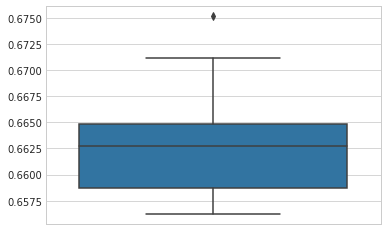

In [13]:
lr_nested_cv_f1_scores = joblib.load(data_type + '_lr_nested_cv_f1_scores.pkl')

plot_cv_scores(lr_nested_cv_f1_scores)

In [14]:
def plot_variable_ranking(model, model_type, column_names):
    if model_type == "rf":
        importance = model.feature_importances_
        importance = pd.DataFrame(importance, index=column_names, columns=["Importance"])
        importance["Std"] = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        
        x = range(importance.shape[0])
        y = importance.ix[:, 0]        
        yerr = importance.ix[:, 1]
        
        plt.bar(x, y, yerr=yerr, align="center")
        plt.xticks(range(len(column_names)), column_names)
        plt.show()
    elif model_type == "lr":
        importance = model.coef_
        importance = pd.DataFrame(importance, index=column_names, columns=["Importance"])
        
        x = range(importance.shape[0])
        y = importance.ix[:, 0]        
        
        plt.bar(x, y, align="center")
        plt.xticks(range(len(column_names)), column_names)
        plt.show()

In [32]:
pca_lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('pca', PCA(random_state=554197)),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid['pca__n_components'] = list(range(2, 14, 2))

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(pca_lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

pca_lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(pca_lr_nested_cv_f1_scores, data_type + '_pca_lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(pca_lr_nested_cv_f1_scores), "std =", np.std(pca_lr_nested_cv_f1_scores))
print

##### Encoded:   Generalization F1 Score: mean = 0.660731584574 std = 0.00561434867445
##### Binarized: Generalization F1 Score: mean = 0.655650138449 std = 0.00599611460643
##### Enriched:  Generalization F1 Score: mean = 0.667960467816 std = 0.00757189854774

[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.622948, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.634689, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.625674, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.641890, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] . lr__C=0.001, pca__n_components=2, score=0.639681, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=2, score=0.631681, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.623079, total=   0.9s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.652061, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645945, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.647838, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


[CV] . lr__C=0.001, pca__n_components=4, score=0.640692, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645279, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.637246, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642088, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.637690, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.641284, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.647469, total=   0.5s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] . lr__C=0.001, pca__n_components=4, score=0.665726, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.660167, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.645563, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.639692, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.645283, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.633048, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


[CV] . lr__C=0.001, pca__n_components=6, score=0.636288, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643486, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.639090, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.647486, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.655922, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.663257, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.642691, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=8, score=0.646969, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


[CV] . lr__C=0.001, pca__n_components=8, score=0.634662, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.634669, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.642291, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.638493, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.648090, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.662529, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.653569, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s


[CV]  lr__C=0.001, pca__n_components=10, score=0.659304, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.651636, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.660560, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.666128, total=   1.0s
[CV]  lr__C=0.001, pca__n_components=10, score=0.658540, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.674587, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.680128, total=   1.0s
[CV] l

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.3s


[CV]  lr__C=0.001, pca__n_components=12, score=0.652435, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.647889, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.657992, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.653384, total=   1.0s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.664527, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.674933, total=   0.9s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.625782, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.3s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.641892, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.626694, total=   0.6s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.633292, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.655011, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649790, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.646923, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.645259, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.1s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.649442, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.667193, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649313, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.641680, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.648827, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.638693, total=   0.5s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.644875, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.1s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.648740, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642090, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.636433, total=   0.7s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.643280, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.643283, total=   0.7s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.636281, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.651282, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.4s


[CV] . lr__C=0.01, pca__n_components=10, score=0.660685, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.669333, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.674271, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.685023, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.665748, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.667642, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.670603, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.4s


[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.643673, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.638290, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.629224, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.636090, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.642492, total=   0.7s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633292, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.627095, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.7s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.649434, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.660481, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.667750, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649511, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.642279, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649420, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.635383, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.9s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.635879, total=   1.0s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.643481, total=   0.8s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.639887, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.651479, total=   0.7s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.664170, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654132, total=   1.0s
[CV] .. lr__C=0.1, pca__n_components=10, score=0.666501, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.664873, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] l

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.5s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.663169, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.669896, total=   0.8s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.663674, total=   1.0s
[CV] .. lr__C=0.1, pca__n_components=12, score=0.667691, total=   1.2s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.625583, total=   0.5s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.675281, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.687991, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.1s


[CV] ..... lr__C=1, pca__n_components=4, score=0.645655, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.640691, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.649434, total=   0.6s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.643278, total=   0.9s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.642264, total=   0.8s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.660275, total=   0.8s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.667750, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   53.1s


[CV] ..... lr__C=1, pca__n_components=8, score=0.635879, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.643481, total=   0.8s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.639885, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.651278, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654132, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.664873, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .... lr__C=1, pca__n_components=10, score=0.666307, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.0s


[CV] .... lr__C=1, pca__n_components=12, score=0.663963, total=   1.0s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.663470, total=   0.7s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.668476, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.668522, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.688199, total=   0.8s
[CV] .... lr__C=1, pca__n_components=12, score=0.674688, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.625583, total=   0.7s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.660275, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.667750, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.649420, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.649511, total=   1.0s
[CV] .... lr__C=10, pca__n_components=6, score=0.642078, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.635383, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.638293, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.666101, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.673188, total=   0.8s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.661957, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.660125, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670860, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.666746, total=   0.8s
[CV] ... lr__C=10, pca__n_components=10, score=0.661085, total=   0.9s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.627095, total=   0.5s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.655000, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.646919, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.649588, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.642480, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.645655, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.640691, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.643676, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.636428, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.643481, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.635879, total=   1.0s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.639885, total=   0.9s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] ... lr__C=100, pca__n_components=8, score=0.651278, total=   0.9s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] ... lr__C=100, pca__n_components=8, score=0.654132, total=   0.9s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.674688, total=   1.0s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.625583, total=   0.4s
[CV] .. lr__C=100, pca__n_components=12, score=0.668522, total=   1.2s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.688215, total=   1.2s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.638290, total=   0.4s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.629224, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.643673, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] .. lr__C=1000, pca__n_components=6, score=0.638293, total=   0.8s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.645072, total=   0.8s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.640871, total=   0.8s
[CV] .. lr__C=1000, pca__n_components=6, score=0.649871, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.659015, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.641689, total=   0.7s
[CV] .. lr__C=1000, pca__n_components=6, score=0.664965, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.663963, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.663470, total=   0.8s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.668476, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.668522, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.674688, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.688215, total=   0.6s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.660428, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636186, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.632270, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.642088, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.625274, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.631288, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV] . lr__C=0.001, pca__n_components=2, score=0.638276, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.631679, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.622272, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651859, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.647446, total=   0.4s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] . lr__C=0.001, pca__n_components=4, score=0.646167, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=4, score=0.638293, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645478, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.636648, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.636893, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642491, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.640685, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


[CV] . lr__C=0.001, pca__n_components=4, score=0.657385, total=   0.5s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.663188, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.636492, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.646577, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643887, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.635687, total=   0.5s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.632663, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


[CV] . lr__C=0.001, pca__n_components=6, score=0.642291, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.639691, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.646488, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.653943, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.646183, total=   0.6s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.662095, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.641878, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


[CV] . lr__C=0.001, pca__n_components=8, score=0.635688, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.634048, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.641488, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.637492, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.654023, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.648490, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.664320, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s


[CV]  lr__C=0.001, pca__n_components=10, score=0.653849, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.649667, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.657175, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.658413, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.663551, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.672116, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.678956, total=   0.8s
[CV]  lr__C=0.001, pca__n_components=12, score=0.651100, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.3s


[CV]  lr__C=0.001, pca__n_components=12, score=0.646891, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.656210, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.654184, total=   0.8s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.661957, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.679013, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.673601, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.635491, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.8s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.654615, total=   0.5s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.634292, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.626093, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649800, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.648348, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.639093, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.639000, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.4s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.657907, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.665889, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649360, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.640489, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.634008, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.637493, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646055, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.3s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.641091, total=   0.6s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.650165, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.637071, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642888, total=   1.1s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.644488, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.638077, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.639690, total=   0.9s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.4s


[CV] . lr__C=0.01, pca__n_components=10, score=0.666521, total=   1.0s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.665771, total=   0.9s
[CV] . lr__C=0.01, pca__n_components=10, score=0.673755, total=   0.7s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.660693, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.685532, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.664040, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.668672, total=   0.9s
[CV] . lr__C=0.01, pca__n_components=12, score=0.662184, total=   1.1s
[CV] l

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.6s


[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.636893, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.643673, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.630009, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634293, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.626695, total=   0.5s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634693, total=   0.6s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.642092, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] l

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.0s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.648448, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=4, score=0.657907, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.666668, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649757, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.640688, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.646646, total=   0.9s
[CV] ... lr__C=0.1, pca__n_components=6, score=0.637693, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.7s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.637879, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654787, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.650688, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.664917, total=   0.9s
[CV] ... lr__C=0.1, pca__n_components=8, score=0.665070, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.663461, total=   1.1s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.671258, total=   1.0s
[CV] .. lr__C=0.1, pca__n_components=10, score=0.663144, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   42.6s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.662474, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.663163, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.664253, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666891, total=   1.1s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666736, total=   1.1s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.673607, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.639182, total=   0.7s
[CV] .. lr__C=0.1, pca__n_components=12, score=0.685695, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.4s


[CV] ..... lr__C=1, pca__n_components=4, score=0.638995, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.639090, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644483, total=   0.6s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.641470, total=   0.8s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.648448, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.666668, total=   0.5s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.657907, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.6s


[CV] ..... lr__C=1, pca__n_components=8, score=0.637879, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.644887, total=   0.7s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.639888, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.650688, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.665070, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654787, total=   1.1s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .... lr__C=1, pca__n_components=10, score=0.666099, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   58.2s


[CV] .... lr__C=1, pca__n_components=12, score=0.663557, total=   1.2s
[CV] .... lr__C=1, pca__n_components=12, score=0.667487, total=   0.8s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.666736, total=   0.8s
[CV] .... lr__C=1, pca__n_components=12, score=0.663853, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.636893, total=   0.4s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.684359, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.673206, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.648448, total=   0.7s
[CV] .... lr__C=10, pca__n_components=4, score=0.657907, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.666668, total=   0.6s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.650154, total=   0.6s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.634403, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646844, total=   0.9s
[CV] .... lr__C=10, pca__n_components=6, score=0.640688, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.663461, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.660979, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.671258, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.663151, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.667667, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.662261, total=   1.0s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.665946, total=   1.0s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.626895, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.654611, total=   0.5s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.648942, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.650180, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.639492, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.646052, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.639090, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.650761, total=   1.0s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.643489, total=   1.0s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.636866, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.641490, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.637879, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.644887, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.639888, total=   0.8s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.666541, total=   1.2s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.673013, total=   1.1s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.684359, total=   0.9s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639182, total=   0.4s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.636893, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.630009, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.634293, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] .. lr__C=1000, pca__n_components=6, score=0.644279, total=   0.8s
[CV] .. lr__C=1000, pca__n_components=6, score=0.638293, total=   0.8s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.641477, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.648070, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.664984, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.657414, total=   1.0s
[CV] .. lr__C=1000, pca__n_components=8, score=0.650761, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.662846, total=   1.1s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.667487, total=   1.1s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.663461, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.684359, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.673013, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.666541, total=   1.1s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.664960, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636386, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.620017, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.644491, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.626267, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.638678, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] . lr__C=0.001, pca__n_components=2, score=0.632081, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.623276, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.647835, total=   0.3s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.652058, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


[CV] . lr__C=0.001, pca__n_components=4, score=0.644778, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.639085, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.647885, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.634467, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642492, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.636690, total=   0.9s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.639689, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


[CV] . lr__C=0.001, pca__n_components=4, score=0.659655, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.647378, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.663597, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.641288, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.631258, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=6, score=0.646683, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s


[CV] . lr__C=0.001, pca__n_components=6, score=0.635278, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.639093, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643491, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.645491, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.655122, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.661906, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.640292, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


[CV] . lr__C=0.001, pca__n_components=8, score=0.633694, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.635428, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.636686, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.642285, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.647487, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.655084, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.652256, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s


[CV]  lr__C=0.001, pca__n_components=10, score=0.663144, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.658610, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.648673, total=   1.0s
[CV]  lr__C=0.001, pca__n_components=10, score=0.651652, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.663163, total=   0.9s
[CV]  lr__C=0.001, pca__n_components=10, score=0.655400, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.671935, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.3s


[CV]  lr__C=0.001, pca__n_components=12, score=0.647289, total=   0.8s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.654808, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.657010, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.663360, total=   1.0s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.673407, total=   0.8s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.623676, total=   0.5s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.637585, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.9s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.634293, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.626294, total=   0.5s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.641092, total=   0.8s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.633893, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.654225, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649593, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.647163, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.7s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.647863, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.666484, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.658400, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649757, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.644462, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.647262, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.633806, total=   0.9s
[CV] .. lr__C=0.01, pca__n_components=6, score=0.637693, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.1s


[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.650368, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.636686, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.637893, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.637466, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.643491, total=   1.0s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.648690, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.653438, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.0s


[CV] . lr__C=0.01, pca__n_components=10, score=0.658737, total=   0.6s
[CV] . lr__C=0.01, pca__n_components=10, score=0.665734, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.665790, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.672583, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.684137, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.662191, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.657833, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.2s


[CV] . lr__C=0.01, pca__n_components=12, score=0.686081, total=   1.1s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.646676, total=   0.8s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.628419, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634493, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.641892, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633894, total=   0.6s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.627095, total=   0.6s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.9s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.647863, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.666679, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.658791, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649956, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647857, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.644062, total=   1.0s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.633997, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.9s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.637667, total=   0.8s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.644090, total=   1.0s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.638093, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.648890, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654031, total=   0.7s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.664764, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=8, score=0.664713, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.1s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.662087, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.661784, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.667299, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.663094, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.665000, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.673770, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.687492, total=   0.9s
[CV] ..... lr__C=1, pca__n_components=2, score=0.624483, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.8s


[CV] ..... lr__C=1, pca__n_components=4, score=0.636428, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644284, total=   0.6s
[CV] ..... lr__C=1, pca__n_components=4, score=0.638092, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.640677, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.648061, total=   0.8s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.666679, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.658791, total=   0.8s
[CV] ..... lr__C=1, pca__n_components=6, score=0.649757, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.9s


[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.637667, total=   0.7s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.644290, total=   0.7s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.638093, total=   1.0s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654031, total=   0.6s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.648890, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.664713, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .... lr__C=1, pca__n_components=10, score=0.657824, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.0s


[CV] .... lr__C=1, pca__n_components=12, score=0.666899, total=   1.1s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.662686, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.665390, total=   0.8s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.673978, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.638382, total=   0.7s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.624483, total=   0.6s
[CV] .... lr__C=1, pca__n_components=12, score=0.685918, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.658791, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.666679, total=   0.7s
[CV] .... lr__C=10, pca__n_components=6, score=0.643861, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.649757, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.648253, total=   0.6s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.634195, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646077, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.664960, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.658019, total=   1.1s
[CV] ... lr__C=10, pca__n_components=10, score=0.671703, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.660165, total=   0.8s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.659733, total=   0.9s
[CV] ... lr__C=10, pca__n_components=10, score=0.662560, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.667887, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] lr__C=100, pca__n_components=2 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.633894, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.627095, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.654422, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.650185, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.647160, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.648676, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.636626, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.643490, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.650567, total=   1.0s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.641486, total=   0.9s
[CV] ... lr__C=100, pca__n_components=8, score=0.636883, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.637667, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.644290, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.638093, total=   0.9s
[CV] ... lr__C=100, pca__n_components=8, score=0.648890, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.665195, total=   0.9s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.673978, total=   1.0s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.685918, total=   1.0s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.638382, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.624483, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.634692, total=   0.5s
[CV] .. lr__C=1000, pca__n_components=2, score=0.628419, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.646077, total=   0.7s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.640282, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.646881, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.657628, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.664416, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.650567, total=   1.1s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.643490, total=   0.8s
[CV] .

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.662488, total=   1.1s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.666899, total=   0.9s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.662972, total=   1.2s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.662882, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.673978, total=   0.8s
[CV] . lr__C=1000, pca__n_components=12, score=0.665195, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.685918, total=   0.8s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.668757, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.3min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.621653, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.630295, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636988, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=2, score=0.637288, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.632489, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=2, score=0.640083, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.647438, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651465, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.639882, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.646964, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


[CV] . lr__C=0.001, pca__n_components=4, score=0.640887, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.637090, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645485, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642088, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.660038, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=4, score=0.639291, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=4, score=0.665931, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.648666, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] l

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s


[CV] . lr__C=0.001, pca__n_components=6, score=0.642654, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=6, score=0.648175, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643291, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=6, score=0.643481, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


[CV] . lr__C=0.001, pca__n_components=6, score=0.643690, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.640689, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.637085, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.645890, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.663084, total=   0.6s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.654714, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.647980, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s


[CV] . lr__C=0.001, pca__n_components=8, score=0.643488, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.654031, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.637492, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.647689, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.663760, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.651811, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.655078, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s


[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.657536, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.651429, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.660954, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.656959, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.663944, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.673084, total=   0.8s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.680483, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.8s


[CV]  lr__C=0.001, pca__n_components=12, score=0.656966, total=   0.8s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.649286, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.658189, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.655739, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.663741, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.674390, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.679519, total=   0.8s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.8s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.632493, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.629495, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.655592, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.648793, total=   0.8s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.649734, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.641259, total=   0.7s
[CV] .. lr__C=0.01, pca__n_components=4, score=0.647076, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.4s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.661378, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646444, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.669219, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.651546, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.647469, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646073, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.645980, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.7s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.649689, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.637460, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.646090, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.645478, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.639691, total=   1.0s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.666074, total=   0.7s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.654413, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.7s


[CV] . lr__C=0.01, pca__n_components=10, score=0.656398, total=   1.0s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.662226, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.668500, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.672298, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.686820, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.662184, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.673649, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.9s


[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.641684, total=   0.6s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.632880, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.624083, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.637087, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.641892, total=   0.7s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.629694, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.632294, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.5s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.661553, total=   0.5s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.668819, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.650040, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.651741, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.646844, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647662, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647162, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.7s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.645888, total=   0.7s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.637456, total=   1.0s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.639890, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.650889, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654211, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.666262, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.666481, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   44.1s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.670696, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.669839, total=   0.8s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.665109, total=   1.2s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.663231, total=   0.8s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.668294, total=   1.1s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.674672, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.639169, total=   0.6s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.5s


[CV] ..... lr__C=1, pca__n_components=4, score=0.642667, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.645265, total=   0.5s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.640292, total=   0.9s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.640275, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.661553, total=   0.5s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.668819, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.650040, total=   0.9s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   53.3s


[CV] ..... lr__C=1, pca__n_components=8, score=0.645076, total=   1.0s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.637456, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.645888, total=   1.0s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.639691, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654211, total=   0.7s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.650889, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .... lr__C=1, pca__n_components=10, score=0.666685, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.2s


[CV] .... lr__C=1, pca__n_components=12, score=0.670034, total=   0.9s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.663613, total=   1.0s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.666106, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.667721, total=   1.2s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.639169, total=   0.7s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.676243, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.687252, total=   0.8s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.668819, total=   0.5s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.661553, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646642, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.651741, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646965, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647860, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646468, total=   0.6s
[CV] .... lr__C=10, pca__n_components=6, score=0.639890, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.659151, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670384, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.668337, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.661116, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.662393, total=   0.8s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670843, total=   1.2s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.673516, total=   0.8s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.641892, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.655784, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.629694, total=   0.8s
[CV] ... lr__C=100, pca__n_components=2, score=0.649188, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.650328, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.640856, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.642667, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.650364, total=   0.9s
[CV] ... lr__C=100, pca__n_components=8, score=0.641678, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.650089, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.645076, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.637456, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.645888, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.639691, total=   0.9s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.667537, total=   0.8s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639169, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.676034, total=   1.0s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.687044, total=   1.1s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.641684, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.624083, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.632880, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] .. lr__C=1000, pca__n_components=6, score=0.646468, total=   0.8s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.642071, total=   0.7s
[CV] .. lr__C=1000, pca__n_components=6, score=0.650064, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.664965, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.656604, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.650364, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.641678, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.668511, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.666506, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.670034, total=   0.9s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.663417, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.676034, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.667537, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.687044, total=   0.5s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.666272, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.1min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.619815, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636187, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636486, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.643884, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.633661, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] . lr__C=0.001, pca__n_components=2, score=0.622274, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651859, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=2, score=0.647438, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.644773, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


[CV] . lr__C=0.001, pca__n_components=4, score=0.637887, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645686, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=4, score=0.641886, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.641290, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.637649, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.640884, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.647076, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] . lr__C=0.001, pca__n_components=4, score=0.666095, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.660968, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.639889, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=6, score=0.647977, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.642275, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643691, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


[CV] . lr__C=0.001, pca__n_components=6, score=0.643091, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.633090, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.646489, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=6, score=0.639492, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.655522, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.662291, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.645983, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s


[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.632893, total=   0.9s
[CV] . lr__C=0.001, pca__n_components=8, score=0.642886, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.636082, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.648290, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.653240, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.661786, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.654309, total=   1.1s
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.6s


[CV]  lr__C=0.001, pca__n_components=10, score=0.651269, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.654403, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.663360, total=   0.8s
[CV]  lr__C=0.001, pca__n_components=10, score=0.658798, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.671121, total=   1.1s
[CV]  lr__C=0.001, pca__n_components=10, score=0.678169, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.649137, total=   1.1s
[CV]  lr__C=0.001, pca__n_components=12, score=0.650827, total=   1.0s
[CV] l

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.3s


[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.663951, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.677245, total=   1.2s
[CV]  lr__C=0.001, pca__n_components=12, score=0.653000, total=   1.2s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.673419, total=   1.3s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.638981, total=   0.5s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.622272, total=   0.5s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.639093, total=   0.5s
[CV] l

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.8s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.635214, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.633292, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.642092, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.655020, total=   0.4s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.625895, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.647154, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649198, total=   0.9s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.6s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.648855, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.667811, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.663078, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649959, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.642868, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646423, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646879, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.8s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.650171, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.650489, total=   0.6s
[CV] .. lr__C=0.01, pca__n_components=8, score=0.640290, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.644480, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.645690, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.634491, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.637293, total=   0.9s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.6s


[CV] . lr__C=0.01, pca__n_components=10, score=0.661108, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.666113, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.667382, total=   1.1s
[CV] . lr__C=0.01, pca__n_components=10, score=0.672805, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.686497, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.661806, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.656463, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   31.2s


[CV] . lr__C=0.01, pca__n_components=12, score=0.685294, total=   1.0s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.639493, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.646852, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.635608, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633493, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.642491, total=   0.7s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.626495, total=   0.6s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.7s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.663273, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.668006, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.650356, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.648072, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=6, score=0.643464, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.641278, total=   0.5s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.644486, total=   0.6s
[CV] ... lr__C=0.1, pca__n_components=6, score=0.635660, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.8s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.645489, total=   0.6s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.637893, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654211, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.649290, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.664503, total=   0.7s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.664364, total=   1.1s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.669723, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   44.5s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.662300, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666498, total=   0.9s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.662678, total=   0.8s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.665623, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.673650, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.687445, total=   0.8s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.638980, total=   0.8s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.8s


[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644666, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644076, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.639795, total=   0.9s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.642462, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.648653, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.663261, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.668006, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   53.8s


[CV] ..... lr__C=1, pca__n_components=8, score=0.634888, total=   0.8s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.644679, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.645688, total=   0.8s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.637893, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.649490, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654211, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.664503, total=   1.1s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.9s


[CV] .... lr__C=1, pca__n_components=12, score=0.666702, total=   0.8s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.673621, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.662081, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.667010, total=   1.4s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.687252, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.638980, total=   0.6s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.622876, total=   0.6s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.648653, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.668200, total=   0.5s
[CV] .... lr__C=10, pca__n_components=4, score=0.663261, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.650356, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647608, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.643464, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.648271, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.656659, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670079, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.659314, total=   1.0s
[CV] ... lr__C=10, pca__n_components=10, score=0.671028, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.668075, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.661689, total=   1.1s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.664785, total=   0.8s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.626495, total=   0.6s
[CV] ... lr__C=100, pca__n_components=2, score=0.655011, total=   0.5s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.633693, total=   0.8s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.649390, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.647469, total=   0.7s
[CV] ... lr__C=100, pca__n_components=4, score=0.640460, total=   0.8s
[CV] ... lr__C=100, pca__n_components=4, score=0.648149, total=   0.8s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.651362, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.644679, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.640689, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.650489, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.634888, total=   1.0s
[CV] ... lr__C=100, pca__n_components=8, score=0.645688, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.649490, total=   0.8s
[CV] ... lr__C=100, pca__n_components=8, score=0.637893, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.673621, total=   0.8s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.638980, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.687252, total=   1.0s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.622876, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639493, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.646852, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.635608, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] .. lr__C=1000, pca__n_components=6, score=0.635660, total=   0.9s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.644486, total=   0.8s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.641477, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.647880, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.651362, total=   0.7s
[CV] .. lr__C=1000, pca__n_components=6, score=0.658224, total=   1.0s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.664398, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.8min


[CV] . lr__C=1000, pca__n_components=12, score=0.666506, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.673621, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.667010, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.662081, total=   1.2s
[CV] . lr__C=1000, pca__n_components=12, score=0.687252, total=   0.4s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.660993, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.9min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.637387, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.644277, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.620234, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.637490, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.627279, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.623882, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651859, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.648228, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=4, score=0.644973, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


[CV] . lr__C=0.001, pca__n_components=4, score=0.640478, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645889, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642084, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.635059, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.640283, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.647677, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=4, score=0.641679, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.664750, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.647579, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643691, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=6, score=0.642484, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643869, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


[CV] . lr__C=0.001, pca__n_components=6, score=0.640490, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.629279, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.638493, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.645291, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.653914, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.662495, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.645782, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


[CV] . lr__C=0.001, pca__n_components=8, score=0.630895, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.639456, total=   0.9s
[CV] . lr__C=0.001, pca__n_components=8, score=0.649490, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.634691, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.652823, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.654294, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.662965, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s


[CV]  lr__C=0.001, pca__n_components=10, score=0.661395, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.658911, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.652864, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.647942, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.654205, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.663772, total=   1.0s
[CV]  lr__C=0.001, pca__n_components=10, score=0.671961, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.5s


[CV]  lr__C=0.001, pca__n_components=12, score=0.649316, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.652481, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.664160, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.653411, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.672824, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.638980, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.623676, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.1s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.634294, total=   0.8s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.633493, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.628096, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.655192, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649000, total=   0.5s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.641259, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.646680, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.8s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.660567, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649760, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.667423, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.641870, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646408, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.647076, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.633229, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.9s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.641883, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.648570, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642683, total=   0.9s
[CV] .. lr__C=0.01, pca__n_components=8, score=0.648688, total=   1.0s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.633481, total=   0.7s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642275, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.637492, total=   0.7s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.8s


[CV] . lr__C=0.01, pca__n_components=10, score=0.655722, total=   1.0s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.661327, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.667382, total=   1.2s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.672182, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.685279, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.670955, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.660795, total=   1.3s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.5s


[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.640688, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.647046, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.628645, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634093, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633294, total=   0.6s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.655389, total=   0.6s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.628495, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.1s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.649853, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.660557, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.667180, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.650356, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.642862, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647273, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.646408, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.4s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.633282, total=   1.0s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.642678, total=   0.9s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.637692, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.650487, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.653175, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.662176, total=   0.6s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.666074, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.4s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.670880, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.663297, total=   0.9s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.664948, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.661093, total=   1.2s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666991, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.638980, total=   0.6s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.673177, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s


[CV] ..... lr__C=1, pca__n_components=4, score=0.646276, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644269, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.637421, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644691, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.642465, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.649853, total=   0.8s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.660557, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.9s


[CV] ..... lr__C=1, pca__n_components=8, score=0.643280, total=   0.6s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.642678, total=   1.0s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.633282, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.637692, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.650487, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.652775, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.666270, total=   0.9s
[CV] .... lr__C=1, pca__n_components=10, score=0.662372, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.5s


[CV] .... lr__C=1, pca__n_components=12, score=0.662489, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.666591, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.673206, total=   1.0s
[CV] .... lr__C=10, pca__n_components=2, score=0.638980, total=   0.8s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.686674, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.624282, total=   0.6s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.640887, total=   0.5s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.649853, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.667180, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.660557, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.650356, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.643061, total=   0.5s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646606, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647273, total=   1.1s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.662372, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.656054, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670651, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670797, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.665348, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.658420, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.660889, total=   1.0s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.633094, total=   0.4s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.628695, total=   0.5s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.649193, total=   0.5s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.655187, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.648348, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.640853, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.646276, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.642080, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.649162, total=   1.0s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.648289, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.643280, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.633282, total=   0.9s
[CV] ... lr__C=100, pca__n_components=8, score=0.642879, total=   0.8s
[CV] ... lr__C=100, pca__n_components=8, score=0.637692, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.666796, total=   1.0s
[CV] .. lr__C=100, pca__n_components=12, score=0.672998, total=   0.9s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.638980, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.624282, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.686482, total=   1.1s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.640887, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.647046, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] .. lr__C=1000, pca__n_components=6, score=0.642692, total=   0.6s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.633229, total=   0.7s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.650069, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.657200, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.640084, total=   1.1s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.664407, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.649162, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.670274, total=   1.1s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.662489, total=   0.7s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.665544, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.666796, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.672998, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.686482, total=   0.6s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.667114, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.7min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.620017, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.643887, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636186, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636486, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.625490, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] . lr__C=0.001, pca__n_components=2, score=0.622674, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=2, score=0.635262, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.644574, total=   0.4s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651264, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.646839, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


[CV] . lr__C=0.001, pca__n_components=4, score=0.640084, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.646678, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.643278, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.636446, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642292, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.632894, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


[CV] . lr__C=0.001, pca__n_components=4, score=0.646674, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.667274, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=4, score=0.661304, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.646775, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.641886, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643680, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643689, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


[CV] . lr__C=0.001, pca__n_components=6, score=0.642291, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.630883, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.635493, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.645489, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.655914, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.663084, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.646379, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


[CV] . lr__C=0.001, pca__n_components=8, score=0.638470, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.629693, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.647486, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.652781, total=   0.6s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.632485, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.660159, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.649820, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s


[CV]  lr__C=0.001, pca__n_components=10, score=0.649489, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.653257, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.652418, total=   1.0s
[CV]  lr__C=0.001, pca__n_components=10, score=0.663169, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.671922, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.650220, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.679149, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.3s


[CV]  lr__C=0.001, pca__n_components=12, score=0.652880, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.649685, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.660590, total=   1.2s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.649434, total=   1.0s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.662947, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.678033, total=   1.0s
[CV]  lr__C=0.001, pca__n_components=12, score=0.674726, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.0s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.633293, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.637684, total=   0.5s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.626294, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.654018, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.646751, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649390, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.641461, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.6s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.649038, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.662643, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.667969, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.644261, total=   0.9s
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649547, total=   1.0s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646269, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.645236, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.0s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.645687, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.646073, total=   0.9s
[CV] .. lr__C=0.01, pca__n_components=8, score=0.631278, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.640883, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.634693, total=   0.9s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.648280, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.654749, total=   0.8s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.7s


[CV] . lr__C=0.01, pca__n_components=10, score=0.665157, total=   0.7s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.668142, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.674719, total=   0.9s
[CV] . lr__C=0.01, pca__n_components=10, score=0.664466, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.685710, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.662160, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.659767, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.2s


[CV] ... lr__C=0.1, pca__n_components=2, score=0.623676, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.645659, total=   0.4s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.639492, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.628454, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.637884, total=   0.4s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633891, total=   0.8s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.626895, total=   0.5s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.7s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.662825, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.668163, total=   0.6s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649544, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.644657, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.646065, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.645632, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.632244, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.6s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.631276, total=   0.7s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.648276, total=   0.7s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.635294, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.641885, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654749, total=   1.1s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.664253, total=   1.2s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.665866, total=   1.2s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.6s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.671416, total=   1.2s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.659170, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666324, total=   0.8s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666952, total=   0.8s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.667987, total=   1.1s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.673785, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.637983, total=   0.6s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s


[CV] ..... lr__C=1, pca__n_components=4, score=0.644650, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.636797, total=   0.8s
[CV] ..... lr__C=1, pca__n_components=4, score=0.634884, total=   0.5s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644688, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.649236, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.662825, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.668163, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.7s


[CV] ..... lr__C=1, pca__n_components=8, score=0.646462, total=   0.8s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.631474, total=   0.8s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.635094, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.641885, total=   1.1s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.648276, total=   1.0s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.664253, total=   0.7s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654946, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.2s


[CV] .... lr__C=1, pca__n_components=12, score=0.668295, total=   1.0s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.667606, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.667362, total=   0.8s
[CV] .... lr__C=1, pca__n_components=12, score=0.674572, total=   0.8s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.637983, total=   0.7s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.686674, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.623676, total=   0.6s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.649236, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.662825, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.668163, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.649742, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.644459, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.645866, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.645632, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.666636, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670491, total=   1.0s
[CV] ... lr__C=10, pca__n_components=10, score=0.658395, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.670651, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.666717, total=   1.2s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.668758, total=   0.8s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.667547, total=   0.8s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.627296, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.654215, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.647148, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.649588, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.641458, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.648067, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.644650, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.643877, total=   0.6s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.648952, total=   1.0s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.646462, total=   0.7s
[CV] ... lr__C=100, pca__n_components=8, score=0.646086, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.631474, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.641885, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.648276, total=   0.8s
[CV] ... lr__C=100, pca__n_components=8, score=0.635094, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.667606, total=   1.1s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.686482, total=   0.8s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.674572, total=   1.1s
[CV] .. lr__C=1000, pca__n_components=2, score=0.637983, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.623676, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.628451, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639492, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.644288, total=   0.8s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.657237, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.636690, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.648075, total=   1.0s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.663828, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.643877, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.648952, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.670651, total=   0.9s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.658937, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.668099, total=   0.8s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.667606, total=   0.7s
[CV] . lr__C=1000, pca__n_components=12, score=0.667362, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.674572, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.686482, total=   0.8s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.663179, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 12.4min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.618801, total=   0.4s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636386, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.643289, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.635883, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.630291, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=2, score=0.624894, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] . lr__C=0.001, pca__n_components=2, score=0.646847, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651859, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.644577, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] . lr__C=0.001, pca__n_components=4, score=0.639485, total=   0.9s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.634467, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.641887, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.646484, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642690, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.646423, total=   0.5s
[CV] . lr__C=0.001, pca__n_components=4, score=0.637893, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


[CV] . lr__C=0.001, pca__n_components=4, score=0.660557, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.663734, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.641487, total=   0.5s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.642692, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.647372, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.630478, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643877, total=   0.8s


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.641290, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.638493, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.655529, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.644465, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.662102, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.645383, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.641892, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


[CV] . lr__C=0.001, pca__n_components=8, score=0.629694, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.636688, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=8, score=0.645063, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=8, score=0.638260, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.654023, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.654672, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.650032, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=8, score=0.662362, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


[CV]  lr__C=0.001, pca__n_components=10, score=0.653462, total=   0.8s
[CV]  lr__C=0.001, pca__n_components=10, score=0.661598, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.648093, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.659712, total=   1.1s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.664105, total=   0.9s
[CV]  lr__C=0.001, pca__n_components=10, score=0.655845, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.671561, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.1s


[CV]  lr__C=0.001, pca__n_components=12, score=0.657353, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.648705, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.652440, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.651287, total=   1.0s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.659311, total=   0.8s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.638186, total=   0.5s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.672399, total=   1.0s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.9s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.627658, total=   0.7s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.635488, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.640491, total=   0.8s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.654031, total=   0.5s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.648802, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.646953, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.640863, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.6s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.648392, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.662289, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.665650, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.648555, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.644856, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646625, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646680, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.8s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.643883, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.646289, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.644082, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.631082, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.641480, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.645854, total=   0.6s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.639093, total=   0.9s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.2s


[CV] . lr__C=0.01, pca__n_components=10, score=0.684538, total=   1.0s
[CV] . lr__C=0.01, pca__n_components=12, score=0.661180, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.673577, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.657050, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.670834, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.671324, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.663998, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.9s


[CV] ... lr__C=0.1, pca__n_components=2, score=0.622870, total=   0.4s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.638383, total=   0.8s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.645854, total=   0.6s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.639693, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.627856, total=   0.4s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633691, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.635881, total=   0.6s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.4s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.648380, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.662083, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.648754, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=4, score=0.666233, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.645050, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.646479, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.632042, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.1s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.640092, total=   1.2s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.654966, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.646246, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.666489, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.665317, total=   1.1s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.657246, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.672264, total=   0.9s
[CV] .. lr__C=0.1, pca__n_components=10, score=0.668953, total=   1.1s
[CV] l

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.6s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.670491, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.665557, total=   0.9s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.668499, total=   1.2s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666032, total=   1.0s
[CV] .. lr__C=0.1, pca__n_components=12, score=0.685324, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.673621, total=   1.2s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.622870, total=   0.5s
[CV] l

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.8s


[CV] ..... lr__C=1, pca__n_components=4, score=0.647267, total=   0.9s
[CV] ..... lr__C=1, pca__n_components=4, score=0.635619, total=   0.5s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.643268, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.643690, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.648380, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.639287, total=   0.8s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.662083, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.8s


[CV] ..... lr__C=1, pca__n_components=8, score=0.643881, total=   1.0s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.631479, total=   0.8s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.640291, total=   0.9s
[CV] ..... lr__C=1, pca__n_components=8, score=0.641882, total=   1.2s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.654966, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.646246, total=   1.1s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.666489, total=   1.1s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.3s


[CV] .... lr__C=1, pca__n_components=12, score=0.665544, total=   1.0s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.668892, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.666432, total=   0.8s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.674007, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.638583, total=   0.5s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.684924, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.622870, total=   0.7s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.648380, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.666027, total=   0.7s
[CV] .... lr__C=10, pca__n_components=4, score=0.662083, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.648754, total=   1.0s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.645450, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647218, total=   0.6s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.646479, total=   1.0s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.666117, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.657059, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.668963, total=   0.8s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.671875, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.657449, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.665748, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.668499, total=   0.9s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.633491, total=   0.7s
[CV] ... lr__C=100, pca__n_components=2, score=0.641292, total=   0.6s
[CV] lr__C=100, pca__n_components=2 ..................................
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.635881, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.654027, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.647151, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.649000, total=   0.8s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.647267, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.649360, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.644279, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.647087, total=   0.9s
[CV] ... lr__C=100, pca__n_components=8, score=0.644080, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.631479, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.641681, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.646444, total=   0.7s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=1000, pca__n_components=2, score=0.638583, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.622870, total=   0.7s
[CV] .. lr__C=100, pca__n_components=12, score=0.684924, total=   1.1s
[CV] .. lr__C=1000, pca__n_components=2, score=0.639693, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.645854, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.627856, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.633491, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] .. lr__C=1000, pca__n_components=6, score=0.632042, total=   1.0s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.644085, total=   0.7s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.646432, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.641889, total=   1.0s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.662849, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.657263, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.649360, total=   0.9s
[CV] .. lr__C=1000, pca__n_components=8, score=0.644279, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.659558, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.668892, total=   0.9s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.665544, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.666237, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.674007, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.684924, total=   0.5s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.663925, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.2min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.644480, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636787, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.619915, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.636486, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.625688, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] . lr__C=0.001, pca__n_components=2, score=0.637881, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.630894, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.633093, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.621425, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.648042, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.639579, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.644771, total=   0.7s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645085, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.634850, total=   0.7s
[CV] . lr__C=0.001, pca__n_components=4, score=0.642279, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=4, score=0.643891, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.637893, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s


[CV] . lr__C=0.001, pca__n_components=4, score=0.642062, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.664925, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642690, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.640979, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.647577, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.642691, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.644068, total=   1.0s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


[CV] . lr__C=0.001, pca__n_components=6, score=0.630280, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.640691, total=   0.8s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.639693, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.640876, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.645982, total=   0.6s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.641489, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.663077, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


[CV] . lr__C=0.001, pca__n_components=8, score=0.639658, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.637879, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=8, score=0.639092, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.642678, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.664745, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.662590, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.653292, total=   1.2s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s


[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.656035, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.656813, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.656356, total=   0.9s
[CV]  lr__C=0.001, pca__n_components=10, score=0.649873, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.679757, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.657366, total=   1.1s
[CV]  lr__C=0.001, pca__n_components=12, score=0.651095, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV] l

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.7s


[CV]  lr__C=0.001, pca__n_components=12, score=0.658350, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.652281, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.655950, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.653623, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.657733, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.679178, total=   1.0s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.621763, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.1s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.628249, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.633489, total=   0.6s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.641492, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.635291, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.626674, total=   0.5s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.647353, total=   0.4s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.649993, total=   0.9s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.8s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.642841, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.644480, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.667605, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.649562, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.644148, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.647469, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.648008, total=   0.9s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.9s


[CV] .. lr__C=0.01, pca__n_components=8, score=0.650359, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.641181, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.644681, total=   0.7s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.651487, total=   1.1s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.633289, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642077, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.640692, total=   0.7s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.9s


[CV] . lr__C=0.01, pca__n_components=10, score=0.665917, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.661748, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.663035, total=   1.1s
[CV] . lr__C=0.01, pca__n_components=10, score=0.685086, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.662739, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.673076, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.673357, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.3s


[CV] . lr__C=0.01, pca__n_components=12, score=0.686627, total=   0.8s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.622773, total=   0.8s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.639093, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.647050, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.628645, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.633888, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634890, total=   0.5s
[CV] lr__C=0.1, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.9s


[CV] ... lr__C=0.1, pca__n_components=4, score=0.645076, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.667605, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649959, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.644342, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647267, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.648803, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.632433, total=   0.7s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.2s


[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.640692, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.641274, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.666300, total=   0.7s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.644290, total=   1.1s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.665104, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.671681, total=   0.7s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.657715, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.4s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.660098, total=   1.1s
[CV] .. lr__C=0.1, pca__n_components=12, score=0.671623, total=   1.2s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.667158, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.659386, total=   0.8s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.667291, total=   1.2s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.665409, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.638779, total=   0.7s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.8s


[CV] ..... lr__C=1, pca__n_components=4, score=0.646870, total=   0.7s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.643265, total=   0.6s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.636606, total=   0.9s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.645888, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.639887, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.643237, total=   0.6s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.645076, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.7s


[CV] ..... lr__C=1, pca__n_components=8, score=0.633087, total=   0.7s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.640692, total=   0.7s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.641677, total=   1.1s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.641274, total=   1.0s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.644290, total=   0.7s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.666300, total=   0.8s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .... lr__C=1, pca__n_components=10, score=0.671886, total=   0.7s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   58.6s


[CV] .... lr__C=1, pca__n_components=12, score=0.659144, total=   1.0s
[CV] .... lr__C=1, pca__n_components=12, score=0.668142, total=   0.8s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.668083, total=   1.1s
[CV] .... lr__C=1, pca__n_components=12, score=0.664440, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.659386, total=   0.8s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.685664, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.638779, total=   0.7s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.643237, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.645076, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.667605, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.650356, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.648600, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.644342, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647267, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.657297, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.671440, total=   0.7s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.671886, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.658537, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.666528, total=   1.0s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.667503, total=   0.8s
[CV] lr__C=10, pca__n_components=12 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.663417, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.641492, total=   0.5s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.634890, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.650585, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.627479, total=   0.8s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.647148, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.641154, total=   0.8s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.646870, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.650554, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.644878, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.651087, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.641677, total=   0.7s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.633087, total=   0.8s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.644290, total=   0.7s
[CV] ... lr__C=100, pca__n_components=8, score=0.641274, total=   0.8s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] ... lr__C=100, pca__n_components=8, score=0.640692, total=   0.9s
[CV] l

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.663836, total=   1.1s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.659377, total=   0.9s
[CV] .. lr__C=1000, pca__n_components=2, score=0.638779, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.685664, total=   1.0s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.622974, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639093, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.647248, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.643491, total=   0.5s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.640856, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.664416, total=   0.9s
[CV] .. lr__C=1000, pca__n_components=8, score=0.650554, total=   1.0s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.651087, total=   0.7s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.641977, total=   0.9s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.633087, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.7min


[CV] . lr__C=1000, pca__n_components=12, score=0.671646, total=   1.1s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.659157, total=   1.0s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.667945, total=   0.9s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.663836, total=   0.8s
[CV] . lr__C=1000, pca__n_components=12, score=0.668083, total=   1.1s
[CV] . lr__C=1000, pca__n_components=12, score=0.659377, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.685664, total=   0.5s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.678658, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.0min remaining:    0.0s


[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.643685, total=   0.5s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.620927, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.636686, total=   0.6s
[CV] . lr__C=0.001, pca__n_components=2, score=0.636786, total=   0.7s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.626886, total=   0.6s
[CV] lr__C=0.001, pca__n_components=2 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.651068, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=2, score=0.621451, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.645168, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.640368, total=   0.7s
[CV] lr__C=0.001, pca__n_components=4 ................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] . lr__C=0.001, pca__n_components=4, score=0.646683, total=   0.5s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642691, total=   0.6s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.644076, total=   0.8s
[CV] . lr__C=0.001, pca__n_components=4, score=0.635852, total=   0.8s
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] lr__C=0.001, pca__n_components=4 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.638492, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


[CV] . lr__C=0.001, pca__n_components=4, score=0.644049, total=   0.5s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.658251, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=4, score=0.642888, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.647976, total=   0.7s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.641974, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.643689, total=   0.6s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.644471, total=   0.9s
[CV] lr__C=0.001, pca__n_components=6 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


[CV] . lr__C=0.001, pca__n_components=6, score=0.639293, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.653378, total=   0.6s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=6, score=0.644290, total=   0.9s
[CV] . lr__C=0.001, pca__n_components=6, score=0.640079, total=   1.0s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.646179, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.638986, total=   0.7s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.631494, total=   0.8s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s


[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.641068, total=   0.9s
[CV] lr__C=0.001, pca__n_components=8 ................................
[CV] . lr__C=0.001, pca__n_components=8, score=0.640284, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.645086, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.640277, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] . lr__C=0.001, pca__n_components=8, score=0.653825, total=   0.7s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.655060, total=   0.8s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.664141, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s


[CV]  lr__C=0.001, pca__n_components=10, score=0.659084, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.649838, total=   1.0s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.653845, total=   1.0s
[CV]  lr__C=0.001, pca__n_components=10, score=0.656422, total=   0.9s
[CV] lr__C=0.001, pca__n_components=10 ...............................
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.657922, total=   1.1s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.675203, total=   0.8s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=10, score=0.662584, total=   1.0s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.4s


[CV]  lr__C=0.001, pca__n_components=12, score=0.647905, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.653477, total=   0.9s
[CV] lr__C=0.001, pca__n_components=12 ...............................
[CV]  lr__C=0.001, pca__n_components=12, score=0.656707, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.654220, total=   1.1s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.661987, total=   0.9s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.638781, total=   0.5s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV]  lr__C=0.001, pca__n_components=12, score=0.676040, total=   1.0s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.623776, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.9s


[CV] .. lr__C=0.01, pca__n_components=2, score=0.633889, total=   0.5s
[CV] .. lr__C=0.01, pca__n_components=2, score=0.627655, total=   0.5s
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] lr__C=0.01, pca__n_components=2 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.640891, total=   0.7s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.633892, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.625286, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=2, score=0.653034, total=   0.6s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.649133, total=   0.8s
[CV] lr__C=0.01, pca__n_components=4 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.5s


[CV] .. lr__C=0.01, pca__n_components=4, score=0.645034, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.644471, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.648566, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=4, score=0.658986, total=   0.7s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.644749, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.646475, total=   0.8s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .. lr__C=0.01, pca__n_components=6, score=0.632038, total=   0.6s
[CV] lr__C=0.01, pca__n_components=6 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.9s


[CV] .. lr__C=0.01, pca__n_components=6, score=0.655507, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.643169, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.648683, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.644865, total=   0.9s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642492, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.642283, total=   0.8s
[CV] lr__C=0.01, pca__n_components=8 .................................
[CV] .. lr__C=0.01, pca__n_components=8, score=0.634082, total=   1.0s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.7s


[CV] . lr__C=0.01, pca__n_components=10, score=0.663360, total=   1.1s
[CV] lr__C=0.01, pca__n_components=10 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.660293, total=   1.0s
[CV] . lr__C=0.01, pca__n_components=10, score=0.668106, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.665214, total=   1.1s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=10, score=0.675667, total=   0.9s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.657892, total=   0.8s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] . lr__C=0.01, pca__n_components=12, score=0.661325, total=   1.0s
[CV] lr__C=0.01, pca__n_components=12 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.0s


[CV] ... lr__C=0.1, pca__n_components=2, score=0.639378, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.639692, total=   0.5s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.646848, total=   0.6s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.623580, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634686, total=   0.7s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.628047, total=   0.7s
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] lr__C=0.1, pca__n_components=2 ..................................
[CV] ... lr__C=0.1, pca__n_components=2, score=0.634491, total=   0.6s
[CV] ... lr__C=0.1, pca__n_components=2, score=0.641492, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.0s


[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=4, score=0.658986, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.649956, total=   0.9s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647071, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=6, score=0.645545, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.647603, total=   0.8s
[CV] lr__C=0.1, pca__n_components=6 ..................................
[CV] ... lr__C=0.1, pca__n_components=6, score=0.632429, total=   0.8s
[CV] ... lr__C=0.1, pca__n_components=6, score=0.644089, total=   0.7s
[CV] ... lr__C=0.1, pca__n_components=6, score=0.642082, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.1s


[CV] ... lr__C=0.1, pca__n_components=8, score=0.642484, total=   1.0s
[CV] lr__C=0.1, pca__n_components=8 ..................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.642292, total=   0.7s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.641663, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.647490, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] ... lr__C=0.1, pca__n_components=8, score=0.655608, total=   0.9s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.664665, total=   1.0s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .. lr__C=0.1, pca__n_components=10, score=0.657111, total=   0.8s
[CV] lr__C=0.1, pca__n_components=10 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.2s


[CV] .. lr__C=0.1, pca__n_components=12, score=0.660719, total=   1.1s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.670880, total=   1.3s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.667095, total=   1.0s
[CV] lr__C=0.1, pca__n_components=12 .................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.666528, total=   1.2s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.663408, total=   1.0s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] ..... lr__C=1, pca__n_components=2, score=0.639378, total=   0.7s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .. lr__C=0.1, pca__n_components=12, score=0.664765, total=   0.9s
[CV] lr__C=1, pca__n_components=2 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s


[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.644852, total=   0.9s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.637197, total=   0.8s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.646285, total=   0.7s
[CV] ..... lr__C=1, pca__n_components=4, score=0.640683, total=   0.5s
[CV] lr__C=1, pca__n_components=4 ....................................
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=4, score=0.645421, total=   0.8s
[CV] ..... lr__C=1, pca__n_components=4, score=0.645066, total=   0.7s
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] lr__C=1, pca__n_components=6 ....................................
[CV] ..... lr__C=1, pca__n_components=6, score=0.650154, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.9s


[CV] ..... lr__C=1, pca__n_components=8, score=0.634676, total=   0.7s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.645457, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.642283, total=   0.9s
[CV] lr__C=1, pca__n_components=8 ....................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.642292, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.641461, total=   0.7s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.647490, total=   0.9s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] ..... lr__C=1, pca__n_components=8, score=0.655805, total=   1.0s
[CV] lr__C=1, pca__n_components=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.1s


[CV] .... lr__C=1, pca__n_components=12, score=0.665938, total=   0.7s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.660346, total=   1.2s
[CV] lr__C=1, pca__n_components=12 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.667895, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.663818, total=   1.0s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.664570, total=   0.9s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=10, pca__n_components=2, score=0.639378, total=   0.6s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .... lr__C=1, pca__n_components=12, score=0.676261, total=   1.1s
[CV] lr__C=10, pca__n_components=2 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


[CV] .... lr__C=10, pca__n_components=4, score=0.645066, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.645421, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=4, score=0.659181, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.650154, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.645747, total=   0.8s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647071, total=   0.9s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .... lr__C=10, pca__n_components=6, score=0.647800, total=   0.7s
[CV] lr__C=10, pca__n_components=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


[CV] ... lr__C=10, pca__n_components=10, score=0.672412, total=   0.8s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.665261, total=   1.3s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.656915, total=   1.1s
[CV] ... lr__C=10, pca__n_components=10, score=0.671269, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.665706, total=   0.9s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.657775, total=   1.1s
[CV] lr__C=10, pca__n_components=10 ..................................
[CV] ... lr__C=10, pca__n_components=10, score=0.668287, total=   1.0s
[CV] ... lr__C=10, pca__n_components=10, score=0.661034, total=   1.0s
[CV] l

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


[CV] ... lr__C=100, pca__n_components=2, score=0.634686, total=   0.7s
[CV] lr__C=100, pca__n_components=2 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.641492, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.634491, total=   0.7s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.625286, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=2, score=0.653034, total=   0.9s
[CV] ... lr__C=100, pca__n_components=4, score=0.641741, total=   0.6s
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] lr__C=100, pca__n_components=4 ..................................
[CV] ... lr__C=100, pca__n_components=4, score=0.649331, total=   0.8s
[CV] ... lr__C=100, pca__n_components=4, score=0.648464, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


[CV] ... lr__C=100, pca__n_components=8, score=0.642283, total=   0.8s
[CV] ... lr__C=100, pca__n_components=8, score=0.634676, total=   0.9s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.645457, total=   1.1s
[CV] lr__C=100, pca__n_components=8 ..................................
[CV] ... lr__C=100, pca__n_components=8, score=0.642292, total=   0.9s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] ... lr__C=100, pca__n_components=8, score=0.655805, total=   0.8s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] ... lr__C=100, pca__n_components=8, score=0.641461, total=   1.1s
[CV] .. lr__C=100, pca__n_components=10, score=0.665261, total=   1.0s
[CV] ... lr__C=100, pca__n_components=8, score=0.647490, total=   1.1s
[CV] lr__C=100, pca__n_components=10 .................................
[CV] l

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


[CV] .. lr__C=100, pca__n_components=12, score=0.663818, total=   0.8s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639378, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.664570, total=   1.1s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=100, pca__n_components=12, score=0.675874, total=   1.1s
[CV] .. lr__C=1000, pca__n_components=2, score=0.623580, total=   0.6s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.639692, total=   0.5s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .. lr__C=1000, pca__n_components=2, score=0.646848, total=   0.7s
[CV] lr__C=1000, pca__n_components=2 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.644089, total=   0.9s
[CV] lr__C=1000, pca__n_components=6 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.642654, total=   0.8s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.646490, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.642082, total=   1.0s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=6, score=0.655703, total=   0.5s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.649953, total=   0.6s
[CV] lr__C=1000, pca__n_components=8 .................................
[CV] .. lr__C=1000, pca__n_components=8, score=0.642966, total=   0.8s
[CV] l

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.8min


[CV] . lr__C=1000, pca__n_components=12, score=0.665938, total=   0.9s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.660346, total=   1.2s
[CV] lr__C=1000, pca__n_components=12 ................................
[CV] . lr__C=1000, pca__n_components=12, score=0.668287, total=   1.0s
[CV] . lr__C=1000, pca__n_components=12, score=0.663818, total=   0.9s
[CV] . lr__C=1000, pca__n_components=12, score=0.664570, total=   0.6s
[CV] . lr__C=1000, pca__n_components=12, score=0.675874, total=   0.6s


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.8min finished


[CV] ................................. , score=0.685318, total= 1.8min
##### Generalization F1 Score: mean = 0.667960467816 std = 0.00757189854774


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.8min finished


<function print>

[ 0.65511154  0.66217525  0.65579536  0.66309076  0.65733756  0.66072978
  0.66125287  0.65229041  0.66813568  0.67139662]



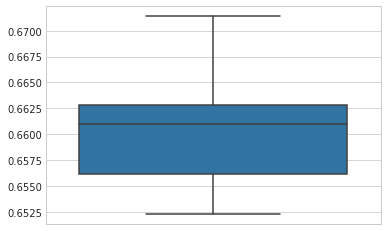

In [19]:
pca_lr_nested_cv_f1_scores = joblib.load(data_type + '_pca_lr_nested_cv_f1_scores.pkl')

plot_cv_scores(pca_lr_nested_cv_f1_scores)

In [33]:
rfe_lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('rfe', RFE(LogisticRegression(class_weight='balanced', random_state=348744), step=4)),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid['rfe__n_features_to_select'] = list(range(5, 18, 5))
param_grid['rfe__estimator__C'] = [0.1, 1, 10]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(rfe_lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

rfe_lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(rfe_lr_nested_cv_f1_scores, data_type + '_rfe_lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(rfe_lr_nested_cv_f1_scores), "std =", np.std(rfe_lr_nested_cv_f1_scores))
print()

##### Encoded:   Generalization F1 Score: mean = 0.681933347276 std = 0.0138063133181
##### Binarized: Generalization F1 Score: mean = 0.661206281182 std = 0.00693543250238
##### Enriched:  Generalization F1 Score: mean = 0.685667061666 std = 0.00621622857699

[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.648280, total=   2.1s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.645961, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671941, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.655435, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.647400, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.655129, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.575848, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662039, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684532, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657301, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664141, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.669255, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664920, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661923, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658166, total=   1.8s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.4s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674461, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681987, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.658600, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663075, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.656133, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666982, total=   2.1s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661617, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660408, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666370, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665062, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.679948, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668200, total=   1.9s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.5s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.647400, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.659971, total=   3.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.655435, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.653142, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.655129, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.575848, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.657301, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.669255, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664141, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664920, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658166, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661923, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.4s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666982, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661617, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666370, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.660408, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665062, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668200, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   33.9s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.647400, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.655435, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.653142, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.655129, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575848, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684532, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   40.9s


[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674461, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.681987, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663075, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.658600, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666982, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   45.9s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.693364, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684121, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.682087, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.694949, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.685004, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668769, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   54.2s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661712, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664653, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.677670, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.683916, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665943, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.664270, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.0min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684121, total=   2.1s
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.693364, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.682087, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.694949, total=   3.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668769, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.685004, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.2min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664653, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.677670, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665943, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.683916, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.664270, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.671623, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668769, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.685004, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.673228, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.679312, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.578494, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.664718, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.5min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671865, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665951, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665509, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669733, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672033, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683587, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657484, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665102, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.672424, total=   2.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667683, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661516, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666850, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.8min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.663331, total=   2.1s
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.665414, total=   2.2s
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.693768, total=   3.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671620, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583358, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674852, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  2.0min


[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673645, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667947, total=   1.6s
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675358, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663123, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.684538, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.675419, 

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.2min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674933, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.666850, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.683709, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666366, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666423, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664182, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.4min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.692309, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660897, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657473, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665509, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.669047, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.671611, total=   2.4s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_se

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.6min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.669884, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671814, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.582954, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.692309, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664718, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.660897, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[C

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.8min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.675062, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.661496, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.662550, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.678913, total=   3.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.664649, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.663884, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.676011, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.684745, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.675251, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.661496, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.662361, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.678157, total=   2.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_se

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.3min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668142, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673449, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662920, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666376, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.676204, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.684938, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.6min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674533, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668142, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673449, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662920, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.676204, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666376, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674533, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663218, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668142, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673449, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662920, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.676204, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  4.1min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674533, total=   2.2s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668142, total=   1.6s
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673449, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662920, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666376, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.676412, total=   1.5s
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.3min


[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668142, total=   2.0s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662920, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.676412, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666376, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.684938, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.675251, 

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.6min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.676412, total=   1.4s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666376, total=   1.8s
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.684938, total=   1.5s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.675251, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.661496, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.662361, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.9min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.675251, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.661496, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.662361, total=   2.3s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.678157, total=   3.0s
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.664649, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.663884, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.2min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.663884, total=   2.3s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.669693, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.671814, total=   2.0s
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583210, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.692309, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.664912, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.4min finished


[CV] ................................. , score=0.687741, total= 5.4min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688860, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.658236, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.677130, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.690046, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.653732, total=   2.0s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.544632, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.575220, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.713757, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658591, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660195, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.654779, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668327, total=   2.0s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661000, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665945, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658403, total=   1.7s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681816, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655420, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.659668, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.656923, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666991, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.2s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661226, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.667970, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660808, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663494, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.681149, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.667288, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.9s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.690046, total=   2.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.655288, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.683026, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.653732, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.598181, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.575220, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.654779, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661000, total=   1.8s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.668327, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.665945, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658403, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661144, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   27.1s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661226, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667970, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663494, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.660808, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667288, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.681149, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.5s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.655288, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.683026, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.653732, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.598181, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.713757, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575220, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.8s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661144, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.675067, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.681816, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659668, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.655420, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.656923, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   44.3s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.689019, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.683015, total=   2.3s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.685699, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.700551, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688317, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688684, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   52.4s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.669864, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661719, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674972, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663861, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682376, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663172, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   59.1s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689019, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.683015, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.685699, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.700551, total=   3.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688317, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688684, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663861, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.674972, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.682376, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663172, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.660677, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670846, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.688684, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.688317, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.690674, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.597097, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.715777, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.579718, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_featu

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.4min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670846, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667361, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671661, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663137, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665632, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671288, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.671452, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664338, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655505, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667487, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660337, total=   1.7s
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.673989, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.8min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668156, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.695535, total=   3.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681946, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670714, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.593199, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583027, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  2.0min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665784, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672648, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661950, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666005, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673111, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.682675, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.2min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.663720, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.673989, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662984, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.683502, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664618, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664806, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.4min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660547, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.692712, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.671841, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655711, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667691, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663557, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_se

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.6min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670333, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.591671, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.692712, total=   1.9s
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.584379, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.662151, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.660547, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[C

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.8min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.672294, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.659224, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.679139, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.695096, total=   3.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.665147, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.678016, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665390, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673898, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683269, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671496, total=   2.2s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.659243, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.695096, total=   2.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666961, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673832, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662134, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665800, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673885, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683463, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.5min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.671404, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673832, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662134, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665800, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673885, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683463, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666961, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671404, total=   2.3s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673832, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662134, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673885, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665800, 

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  4.0min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666961, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.671404, total=   2.3s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673832, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662134, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673885, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665800, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.3min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666961, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673832, total=   1.5s
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662134, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665800, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673885, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683463, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.5min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665800, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673885, total=   1.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683463, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671496, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.679139, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.659243, total=   2.3s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.8min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671496, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.659243, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.679139, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.695096, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.665147, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.677831, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.1min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670333, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.590812, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.692712, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.584599, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661955, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660350, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.3min finished


[CV] ................................. , score=0.696094, total= 5.3min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.7min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.685667, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.658236, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.661758, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.692714, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.653929, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.658838, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.575443, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.711879, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658206, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656911, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.654007, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.671886, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660808, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665551, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658205, total=   1.7s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682011, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661644, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.656329, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.670798, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655343, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.9s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661631, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.659239, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666381, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.664678, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.667288, total=   1.5s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.679047, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.1s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.655288, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.692714, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.683026, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.653929, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.658838, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.575443, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.671886, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.660808, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658205, total=   1.5s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.665551, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659760, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.674689, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.8s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.655343, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661631, total=   1.6s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666381, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.659239, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.664678, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667288, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.2s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.655288, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.683026, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.653929, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.658838, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575443, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.711879, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   39.1s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674689, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659760, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682011, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661644, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.656329, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.655343, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   44.6s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688872, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.690077, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684877, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.700487, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688317, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.686845, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   52.3s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661130, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663901, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.675021, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681198, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662976, total=   1.3s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.658605, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   58.1s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688872, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.690077, total=   2.5s
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684877, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.700487, total=   3.3s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688317, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.686845, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.675021, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.681198, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662976, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658605, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674025, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661493, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.688317, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.686845, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.689201, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.682740, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.578832, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.715595, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_featu

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.4min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665981, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670100, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667577, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663551, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671535, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683836, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655127, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661575, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.676028, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666913, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665531, total=   1.7s
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660337, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.8min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.697437, total=   2.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.663847, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.661574, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.667172, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674431, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.692524, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.9min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666579, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672877, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661923, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666786, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674285, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683449, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.673625, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682921, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659825, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661617, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663232, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675760, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657833, total=   1.5s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655722, total=   1.5s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660195, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.675615, total=   2.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666513, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665131, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.5min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.666062, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.669743, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583721, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.686408, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661368, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.657833, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[C

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.671532, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.665895, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.678811, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.697987, total=   3.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.662159, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.659471, total=   2.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675294, total=   1.5s
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667801, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.684029, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.670784, total=   2.3s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.662361, total=   1.8s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665726, total=   2.2s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665778, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673073, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662890, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.667792, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.675487, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683435, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.5min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663025, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665778, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673073, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662890, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675487, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667792, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663025, total=   1.6s
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675979, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673073, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665778, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667792, total=   1.6s
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662890, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  4.0min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.675979, total=   2.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673073, total=   1.3s
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665778, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662890, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.667792, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.675487, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665778, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673073, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662890, total=   1.7s
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667792, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675487, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683435, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.5min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683435, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.670784, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.662361, total=   1.9s
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665726, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.698171, total=   2.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.662159, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.8min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670784, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.665726, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.662361, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.698171, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.662159, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.659471, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.1min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.666044, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.669743, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583721, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.686408, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660976, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.657833, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.3min finished


[CV] ................................. , score=0.688103, total= 5.3min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.1min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.657280, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687935, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.693764, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.678344, total=   2.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.652952, total=   2.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.664777, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.705007, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659955, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.709744, total=   2.5s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.8s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658259, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657753, total=   2.2s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663713, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663551, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665524, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.6s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660410, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660926, total=   1.8s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.659620, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666859, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.9s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.664387, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668935, total=   1.8s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660978, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666628, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668237, total=   1.9s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.684237, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.7s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.654593, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684109, total=   3.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.652952, total=   3.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.664777, total=   3.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.705007, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.709744, total=   3.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.7s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663713, total=   2.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.657753, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.665524, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663551, total=   2.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658572, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661163, total=   2.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.0s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.664387, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668935, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.660978, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666628, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668237, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.684237, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   42.3s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.654593, total=   3.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684109, total=   3.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.652952, total=   2.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.664777, total=   3.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659955, total=   2.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.705007, total=   3.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe_

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   52.6s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661163, total=   2.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.676222, total=   2.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.683540, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660410, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659620, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666859, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   59.6s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688320, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.692723, total=   2.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.691649, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.697621, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688024, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687360, total=   2.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.2min


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668629, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661916, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664253, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.677283, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682727, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665066, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.692723, total=   3.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688320, total=   3.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.691649, total=   3.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.697621, total=   3.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688024, total=   2.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.687360, total=   3.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.5min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664253, total=   2.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.682727, total=   2.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.677283, total=   2.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665066, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.659519, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666777, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.688024, total=   3.3s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.687360, total=   3.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.689570, total=   3.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.698706, total=   3.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.704991, total=   3.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.715865, total=   3.3s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_featu

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.9min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673227, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674201, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668911, total=   2.3s
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664678, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.686334, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.673395, total=   2.7s
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665109, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660104, total=   2.3s
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667947, total=   2.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.669038, total=   2.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660897, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.677657, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  2.4min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.685004, total=   3.3s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.686807, total=   2.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.682606, total=   3.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673144, total=   3.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.675404, total=   3.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.700156, total=   3.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  2.6min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670092, total=   2.5s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675015, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.664245, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668867, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675343, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.685710, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.9min


[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.666432, total=   3.0s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.684277, total=   2.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665504, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662506, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675178, total=   2.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.66

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.1min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661325, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659757, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668142, total=   2.5s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660881, total=   2.4s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664309, total=   2.4s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668442, total=   2.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  3.4min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681612, total=   3.2s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5 .......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671219, total=   3.2s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674832, total=   3.4s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.699475, total=   3.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661325, total=   2.6s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659757, total=   2.8s
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  3.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.672104, total=   3.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.688613, total=   3.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.685556, total=   3.5s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.691486, total=   3.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.681612, total=   3.3s
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.666864, total=   3.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668066, total=   2.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.676338, total=   2.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.686096, total=   2.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671532, total=   2.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687913, total=   2.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.685556, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  4.4min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.675015, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666181, total=   2.2s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.676145, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668066, total=   2.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.686289, total=   2.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671532, total=   3.0s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  4.7min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669292, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675015, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666181, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668066, total=   2.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.676145, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.686289, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.1min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675967, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669106, total=   2.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669292, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675015, total=   2.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666181, total=   2.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668066, total=   2.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  5.5min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669106, total=   2.1s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669292, total=   2.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674623, total=   2.3s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666181, total=   2.3s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668066, total=   2.2s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.676145, total=   2.2s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.8min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669292, total=   2.7s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674623, total=   2.7s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666181, total=   2.5s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668066, total=   2.5s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.676145, total=   2.9s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.686289, total=   2.7s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  6.3min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.676145, total=   2.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.686289, total=   2.5s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671532, total=   2.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687913, total=   2.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.683784, total=   2.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.691486, total=   2.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  6.6min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671532, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.687913, total=   3.3s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.683784, total=   3.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.691486, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.666673, total=   3.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681797, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  7.1min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.671219, total=   3.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.671987, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.699656, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.710815, total=   3.4s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661734, total=   3.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659952, total=   2.6s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  7.4min finished


[CV] ................................. , score=0.686331, total= 7.4min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.5min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.651210, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.657473, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688165, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.680092, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.683212, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.653929, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.659033, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.575038, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.711879, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657806, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655732, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662751, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657628, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668963, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664967, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.4s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659569, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674884, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682022, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661047, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.656329, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663372, total=   1.4s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.657405, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666381, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.657841, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663101, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665914, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.678246, total=   1.4s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.682546, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.683212, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.680092, total=   3.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.653929, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.575038, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.659033, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.657628, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.668963, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658200, total=   1.7s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664967, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659569, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.674884, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.1s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.657405, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665258, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666381, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.657841, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663101, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665914, total=   1.4s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   31.9s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.682546, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.683212, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.653929, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.659033, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575038, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.711879, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.2s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659569, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674884, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682022, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661047, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.656329, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663372, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   43.4s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.689019, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688886, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.690811, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.696559, total=   2.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688075, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.686624, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   51.2s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668303, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660547, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663690, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.676016, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681392, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663180, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   57.5s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689019, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.690811, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688886, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.696559, total=   2.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688075, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.686624, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663690, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663180, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.681392, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.676016, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658633, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666833, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.688075, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.689681, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.579015, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.682740, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.715960, total=   2.1s
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660764, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.4min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670107, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664244, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668695, total=   2.3s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663734, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669984, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666805, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659582, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674060, total=   2.3s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667306, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660140, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664141, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674608, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.7min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684707, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.696520, total=   3.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.664054, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.669443, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674621, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583686, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.9min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.671504, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662323, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665614, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674272, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683643, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.672104, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.664141, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674608, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682727, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661413, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659834, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671324, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658419, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663844, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659377, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.673260, total=   2.3s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667706, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660330, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.5min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.660637, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5 .......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.666962, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674069, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583756, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.692175, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.660976, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668484, total=   1.9s
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.671496, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668050, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.695167, total=   3.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.664702, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.660637, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.9min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665623, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674479, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683629, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671496, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.667370, total=   2.0s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668050, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672812, total=   2.3s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672689, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661523, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665828, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674866, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683836, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.4min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665191, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672689, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672812, total=   2.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661523, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665828, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674866, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671724, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665191, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672689, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672812, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661523, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665828, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  3.9min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665191, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672812, total=   2.3s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661523, total=   1.4s
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672689, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665828, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674866, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672689, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672812, total=   2.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661523, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674866, total=   1.4s
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665828, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683643, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.4min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674866, total=   1.3s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665828, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683643, total=   1.5s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671496, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.667370, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668050, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.7min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671496, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.667370, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668050, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681353, total=   3.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.664346, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.660637, total=   2.0s
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.0min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.666962, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670091, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.692175, total=   1.9s
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583537, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660976, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.658224, total=   1.6s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.2min finished


[CV] ................................. , score=0.684481, total= 5.2min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 28.7min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.657474, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688832, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.680048, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.681997, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.657334, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.667253, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.575443, total=   1.9s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658402, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.713428, total=   1.8s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656133, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663951, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.651011, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661772, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668737, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.2s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659575, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674494, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681427, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661853, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655922, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665144, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663622, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.658839, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666487, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.664890, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.680567, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.657474, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.8s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681997, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.659196, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689416, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.657334, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.667253, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658402, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_feat

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663951, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.651011, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.668737, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661772, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.657400, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659575, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.4s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.653157, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666475, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663622, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658839, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.664890, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666487, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.1s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.681997, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.659196, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.657334, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.667253, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575443, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.658402, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe_

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.0s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659575, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674494, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661853, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.681427, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.655922, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665144, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   43.9s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688320, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.689565, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688821, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684209, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.698066, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687103, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   51.5s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666091, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660350, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663690, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674850, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663360, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681587, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   58.1s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688320, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689565, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688821, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684209, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.698066, total=   3.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.687103, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663690, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.674850, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663360, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.681587, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658615, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670339, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.698066, total=   3.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.687103, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.689975, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.700986, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.580343, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661351, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.4min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660913, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670902, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668364, total=   1.6s
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663957, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667206, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671729, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664262, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655459, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666083, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.673671, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660133, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666513, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.7min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.678027, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.663081, total=   2.1s
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.666216, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.693770, total=   3.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673687, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659987, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.9min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673819, total=   2.4s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662927, total=   1.2s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669029, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675860, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683587, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670958, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.666513, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674632, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662010, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.681793, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660234, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672103, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664253, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658028, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655835, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.672676, total=   2.5s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667455, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659747, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.5min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.664931, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.669359, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.687920, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583098, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.660380, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658028, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[C

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670453, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668114, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.664745, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.677740, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.693954, total=   3.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.664931, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668620, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675294, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683794, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.670453, total=   2.2s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668114, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.664745, total=   2.0s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674814, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663509, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669552, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668620, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.675487, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683601, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.4min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661808, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669552, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663509, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674814, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668620, total=   1.8s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675487, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672698, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661808, total=   1.6s
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674814, total=   2.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669552, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663509, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668620, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  4.0min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674814, total=   2.2s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669748, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663509, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668620, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.675487, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683601, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669748, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674814, total=   2.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663509, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668620, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.675487, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683601, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.5min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668620, total=   1.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.675487, total=   1.5s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683601, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.670453, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668114, total=   2.0s
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.664745, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.8min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668114, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670453, total=   2.4s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.664745, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.677923, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.661391, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.693954, total=   3.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.1min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.665314, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.669359, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583098, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.687920, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660387, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.658233, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.3min finished


[CV] ................................. , score=0.688702, total= 5.3min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 34.0min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.650817, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.643026, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.659404, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.674062, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.652539, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.641043, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.655522, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.680237, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658959, total=   1.5s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.679168, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658063, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665675, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.654726, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.671052, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663163, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662527, total=   1.4s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662134, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674655, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.683177, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661406, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655695, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665494, total=   1.6s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663626, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666141, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.666271, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.667253, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.680943, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.1s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674062, total=   2.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670673, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.652539, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.641043, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.655522, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.680237, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.654726, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.671052, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663163, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.662527, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.662134, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661406, total=   1.4s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.7s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.654304, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663626, total=   1.4s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668397, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666141, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666271, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667253, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.6s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.652539, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.641043, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.680237, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.655522, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.679168, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.658959, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe_

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.5s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674655, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.662134, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.683177, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661406, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665494, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.655695, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   44.3s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.675675, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687765, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.690327, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684427, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.674062, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.680659, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   52.1s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663853, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665131, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665249, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.675888, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682714, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665308, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   58.1s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.675675, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.687765, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.690327, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674062, total=   3.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684427, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673038, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.675888, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665308, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.682714, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658340, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670739, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.66

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684427, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.680659, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.673038, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.678887, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.703679, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661298, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.4min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671246, total=   2.1s
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662431, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669952, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667659, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.666181, total=   1.5s
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672018, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667577, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656430, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674352, total=   2.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663690, total=   1.6s
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665531, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664662, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.8min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674062, total=   3.3s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681025, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671259, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.657713, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.676315, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.690916, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  2.0min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.671139, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669402, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665535, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673414, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.682606, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.673395, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.664662, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.676883, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665308, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.683903, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.658391, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672653, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660352, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667577, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656054, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.675153, total=   2.4s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664941, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662701, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.5min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670687, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5 .......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.656167, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673305, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689201, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.694373, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661334, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.672083, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668451, total=   2.1s
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668932, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.674062, total=   3.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.680198, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670687, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665124, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674809, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683615, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.672083, total=   2.0s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668787, total=   2.0s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.666803, total=   2.2s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673744, total=   2.2s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.671125, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669607, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665124, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674616, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683629, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.5min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663781, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673744, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.671125, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669607, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665124, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674616, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673637, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663781, total=   1.8s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673744, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671125, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669607, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665124, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  4.0min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.670929, total=   1.4s
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663781, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673744, total=   2.1s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669607, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665124, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674616, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673744, total=   2.3s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670929, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669607, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665124, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674616, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683629, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.5min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665124, total=   1.5s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674616, total=   1.4s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683629, total=   1.4s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.672083, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.666803, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668787, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.8min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.672083, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668787, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.666803, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.674062, total=   2.8s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.680198, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670687, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.1min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.656167, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670687, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.673305, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.689201, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661334, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.694373, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.3min finished


[CV] ................................. , score=0.690820, total= 5.3min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 39.3min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.650810, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.662645, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.643026, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.653135, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.646234, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.660915, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.575220, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.685269, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658583, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656299, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664513, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.654943, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664178, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674025, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663772, total=   1.6s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665334, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.673866, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682400, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655136, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660050, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662954, total=   1.2s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.7s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.654142, total=   1.4s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660856, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665790, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662995, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665719, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.680579, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.2s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.658358, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.653135, total=   3.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.652735, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.646234, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.660915, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.575220, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.674025, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.654943, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663772, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664178, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.665334, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.673866, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.0s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.654142, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.666628, total=   2.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665790, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.660856, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662995, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665719, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.3s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.653135, total=   3.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.652735, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.646234, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.660915, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575220, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.685269, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.7s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.665334, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.673866, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682400, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660050, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.655136, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662954, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   44.6s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.676010, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.689253, total=   1.9s
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.669786, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.681389, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.695428, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665325, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   52.0s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664154, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668672, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.676755, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666458, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.681575, total=   2.0s
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661980, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   59.1s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.676010, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.669786, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689253, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.681389, total=   2.3s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.695428, total=   3.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673206, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.666458, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.676755, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.681575, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.657441, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661980, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668768, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.695428, total=   3.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.665325, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.673206, total=   2.3s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.682878, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.579015, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660916, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.5min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660512, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670296, total=   2.2s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665213, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670688, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667879, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671121, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663061, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655299, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674402, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664363, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667495, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664898, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.8min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.663103, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.679834, total=   2.7s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.667858, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.661134, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.582771, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.675884, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.9min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673589, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668381, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670492, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665837, total=   1.3s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673484, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683255, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.674377, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682752, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661187, total=   1.6s
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.658019, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671160, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668381, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658801, total=   1.5s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662073, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655288, total=   1.5s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662003, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674013, total=   2.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.667503, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.5min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.658723, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673016, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583466, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.691502, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.662543, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658801, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[C

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.671878, total=   2.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.666487, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.666272, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.679480, total=   3.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.661015, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.666744, total=   2.3s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674285, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683656, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671304, total=   1.8s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665529, total=   1.8s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665747, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.679480, to

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661808, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668370, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.670114, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665232, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674479, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683463, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.4min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661808, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668370, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673807, total=   2.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670114, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674479, total=   1.2s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665232, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.671160, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661808, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668370, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673807, total=   2.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670114, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665232, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  3.9min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661808, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668370, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673807, total=   2.2s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.670114, total=   1.3s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665232, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.683463, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673807, total=   2.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668370, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665232, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670114, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674479, total=   1.3s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.683463, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.4min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665232, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674479, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.683463, total=   1.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.671304, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665529, total=   1.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.665938, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.7min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.671304, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.665938, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.665529, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.660637, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.679480, total=   2.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.666360, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.0min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.658723, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.673016, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.691502, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583686, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.662543, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.658596, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.2min finished


[CV] ................................. , score=0.671852, total= 5.2min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 44.5min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.562383, total=   1.7s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.558744, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.693023, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.689394, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.8s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684109, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658959, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.567981, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.574424, total=   1.7s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.657383, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663957, total=   1.5s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.666083, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655082, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.672788, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663957, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655472, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656750, total=   1.5s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682970, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660227, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.664913, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.654824, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.3s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.656122, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.661455, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665981, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.659820, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.657733, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.680774, total=   1.4s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.5s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.690142, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.565184, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689394, total=   2.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.679924, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.567981, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.574424, total=   1.9s
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_feat

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.5s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.655082, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.672788, total=   2.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663957, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663957, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.655472, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.656750, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   24.6s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.656122, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.667596, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.661455, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.665981, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.659820, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.657733, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   30.1s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.689394, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.565184, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.679924, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684109, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.567981, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.574424, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   36.0s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.655472, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682970, total=   1.6s
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.656750, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660227, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.654824, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664913, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   41.2s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.561295, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.568758, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688376, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.699047, total=   2.3s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.685299, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.569858, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   49.0s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658205, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663202, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658276, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.682908, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.658711, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.671118, total=   1.3s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   55.0s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.585069, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.568758, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688376, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.685299, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.699047, total=   2.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684489, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658205, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.658276, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663202, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658711, total=   1.4s
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.682908, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.671118, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.699047, total=   2.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.569858, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684489, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.691505, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.571525, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661298, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672642, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.661300, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667400, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669103, total=   1.3s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662763, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659396, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665819, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656430, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664520, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674814, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668310, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656813, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.679551, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.696704, total=   2.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.570842, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.661476, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.576334, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.673616, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.8min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673188, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673236, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.658829, total=   1.3s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662920, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.684416, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583781, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.0min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.656813, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660912, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.682558, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660183, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660293, total=   1.2s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672687, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.2min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659987, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659883, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665418, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656248, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674584, total=   2.3s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668703, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.4min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.570929, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5 .......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.658322, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.575970, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670248, total=   2.1s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659987, total=   1.6s
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.582519, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.6min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.583965, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668071, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.574230, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.678576, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.694285, total=   3.1s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.570929, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663901, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659024, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.684596, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.567543, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.574047, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668071, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.0min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672648, total=   1.2s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669532, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663501, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.659024, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.684402, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583965, total=   2.1s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669532, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662416, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673964, total=   2.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672648, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663501, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.659024, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673488, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673964, total=   2.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662416, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.669532, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672648, total=   1.3s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659024, total=   1.4s
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  3.7min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662624, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.669532, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.673964, total=   2.0s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672648, total=   1.2s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663501, total=   1.2s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.659220, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.0min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.673964, total=   2.2s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669532, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672648, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663501, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.659220, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.684402, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663501, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.684402, total=   1.6s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.659220, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.567543, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.574047, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.668071, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.5min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.583965, total=   2.3s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.574047, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668071, total=   2.3s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.694285, total=   3.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.678576, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.571378, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  4.8min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.658322, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670248, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.582740, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575566, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659987, total=   1.7s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659688, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_fea

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.0min finished


[CV] ................................. , score=0.680822, total= 5.0min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 49.5min remaining:    0.0s


[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.541821, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.558159, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.691225, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.687341, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV]  lr__C=0.001, rfe__esti

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.676944, total=   1.8s
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.565136, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5 .
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.670210, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659555, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.601079, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.566927, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.656991, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665879, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.654499, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.673018, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663957, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664948, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.3s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661754, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.659163, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.675100, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.660606, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655195, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.665509, total=   1.5s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.1s


[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.655265, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662431, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15 
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668142, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662166, total=   1.3s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663109, total=   1.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668983, total=   1.4s
[CV] lr__C=0.001, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.1s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.689811, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.687341, total=   2.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.565136, total=   2.2s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.676944, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670210, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.566927, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_featu

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.654499, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.673018, total=   2.5s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.664948, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661754, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663957, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.659163, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.4s


[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.655265, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662431, total=   1.6s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.669754, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668142, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662166, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663109, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.2s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.687341, total=   3.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.565136, total=   2.1s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.676944, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.670210, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.601079, total=   2.0s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.566927, total=   1.9s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.3s


[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661754, total=   1.8s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.675100, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.659163, total=   1.7s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.660606, total=   1.4s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.655195, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15 .
[CV]  lr__C=0.001, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.665509, total=   1.5s
[CV] lr__C=0.001, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   43.9s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.543830, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.560564, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.688154, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.696848, total=   2.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.684391, total=   1.8s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.569316, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   51.5s


[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.665151, total=   1.9s
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.669660, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10 .
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663282, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660897, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663521, total=   1.4s
[CV] lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=15 .
[CV]  lr__C=0.01, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.677193, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   58.0s


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.560564, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.593207, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.688154, total=   2.3s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.696848, total=   2.8s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.684391, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.569316, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min


[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.663282, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.660897, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.677193, total=   1.7s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663521, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.659297, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.01, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.670913, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=1, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684391, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.569316, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.684489, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.691544, total=   2.0s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.600779, total=   2.1s
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.575079, total=   1.9s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_featu

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.4min


[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672788, total=   2.1s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662045, total=   1.5s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.667964, total=   1.6s
[CV] lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.670076, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662920, total=   1.4s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=0.01, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.664990, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655459, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674402, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664548, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.668499, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.662293, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=0.1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.660954, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=0.1, rfe__n

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.7min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.678353, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.570662, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.695351, total=   3.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.656772, total=   2.1s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.670818, total=   1.9s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=10 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.578572, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.9min


[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674571, total=   2.2s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668764, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672265, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662505, total=   1.3s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.679313, total=   1.4s
[CV]  lr__C=0.1, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662831, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min


[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.662293, total=   1.8s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.676404, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.660954, total=   2.0s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662517, total=   1.7s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.657501, total=   1.6s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15 ...
[CV]  lr__C=0.1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.673109, total=   1.5s
[CV] lr__C=0.1, rfe__estimator__C=10, rfe__n_featur

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.661164, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.658292, total=   1.6s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.663640, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.674220, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.655471, total=   1.7s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10 ....
[CV]  lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_select=10, score=0.664357, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=0.1, rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  2.5min


[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.572092, total=   2.3s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5 .......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.656772, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.668959, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.593572, total=   2.2s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.578832, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10 ......
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.661164, total=   1.9s
[CV]  lr__C=1, rfe__estimator__C=1, rfe__n_features_to_select=10, score=0.

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.7min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.567630, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.586851, total=   1.9s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.664646, total=   2.4s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.678289, total=   1.8s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.680626, total=   3.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 ......
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.572092, total=   2.0s
[CV] lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=5 .....

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min


[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672469, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662421, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.679507, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.568079, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.552522, total=   2.0s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ....
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.663160, total=   1.9s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_sel

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.2min


[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674584, total=   2.0s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668521, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ...
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672273, total=   1.2s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.663078, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662235, total=   1.4s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=5 ......
[CV]  lr__C=10, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.679313, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  3.4min


[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662401, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668521, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674584, total=   2.3s
[CV] lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672273, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.663078, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=5 .....
[CV]  lr__C=10, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.679313, total=   1.3s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min


[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672915, total=   1.5s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662401, total=   1.6s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.674584, total=   2.3s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.668521, total=   1.7s
[CV] lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15 ....
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.672273, total=   1.5s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ...
[CV]  lr__C=10, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.663078, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  3.9min


[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662208, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.674584, total=   2.1s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.668521, total=   1.7s
[CV] lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15 ..
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.672273, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662882, total=   1.2s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=5 .....
[CV]  lr__C=100, rfe__estimator__C=0.1, rfe__n_features_to_select=15, score=0.662235, total=   1.6s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.2min


[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.674584, total=   2.3s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662882, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.668521, total=   2.0s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.672273, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.662235, total=   1.8s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=5 ....
[CV]  lr__C=100, rfe__estimator__C=1, rfe__n_features_to_select=15, score=0.679120, total=   1.4s
[CV] lr__C=100, rfe__estimator__C=10, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  4.5min


[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662882, total=   1.4s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.662235, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=100, rfe__estimator__C=10, rfe__n_features_to_select=15, score=0.679120, total=   1.5s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.568079, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.552749, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5 ..
[CV]  lr__C=1000, rfe__estimator__C=0.1, rfe__n_features_to_select=5, score=0.663160, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=0.1, rfe__n_f

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  4.7min


[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.586423, total=   2.0s
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.568079, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.663160, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.678289, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.680626, total=   3.0s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5 ....
[CV]  lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_select=5, score=0.572135, total=   2.2s
[CV] lr__C=1000, rfe__estimator__C=1, rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  5.1min


[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.680626, total=   3.3s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5 ...
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.655445, total=   1.9s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.668959, total=   2.1s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.593946, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=5, score=0.579054, total=   2.0s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10 ..
[CV]  lr__C=1000, rfe__estimator__C=10, rfe__n_features_to_select=10, score=0.661359, total=   1.8s
[CV] lr__C=1000, rfe__estimator__C=10, rfe__n_feat

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.3min finished


[CV] ................................. , score=0.681725, total= 5.3min
##### Generalization F1 Score: mean = 0.685667061666 std = 0.00621622857699



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 54.8min finished


[ 0.67638402  0.68867139  0.68302557  0.683188    0.65738547  0.68089781
  0.6856038   0.66147249  0.69704049  0.70566443]



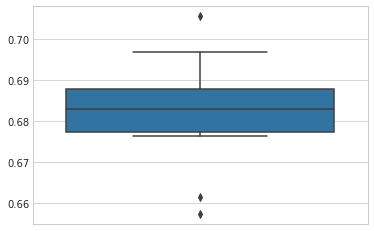

In [20]:
rfe_lr_nested_cv_f1_scores = joblib.load(data_type + '_rfe_lr_nested_cv_f1_scores.pkl')

plot_cv_scores(rfe_lr_nested_cv_f1_scores)